# Airbnb Capstone Project

## 1.Import all Libraries

In [92]:
### import all libraries and set settings 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import gzip
import pyproj
import math

from py_functions import increase_bbox 
from sklearn.neighbors import BallTree
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import transform
from functools import partial

pd.set_option('display.max_columns', None) # show all columns  

## 2.Inside Airbnb pipeline

In [93]:
### Define path, .gz archive file name, country and city for url
path ='data/'
gz_file = "listings.csv.gz"
country = "united-kingdom"
state = "england"
city = "london"
url = f"http://data.insideairbnb.com/{country}/{state}/{city}/2023-03-14/data/{gz_file}"

In [94]:
### Create new directory for city
!mkdir {path}{city}

mkdir: data/london: File exists


In [95]:
### Download the .gz file
r = requests.get(url)
with open(path+city+'/'+gz_file, 'wb') as f:
    f.write(r.content)

In [96]:
### Unzip the .gz file and save the content as pd.DataFrame via read_csv
with gzip.open(path+city+'/'+gz_file) as f:
    listings = pd.read_csv(f)


In [97]:
### select only desired columns 
columns_keeper = (["id",
                   "listing_url",
                   "name",
                   "picture_url",
                   "host_id",
                   "host_response_rate",
                   "host_acceptance_rate",
                   "host_is_superhost",
                   "host_listings_count",
                   "host_total_listings_count",
                   "neighbourhood_cleansed",
                   "latitude",
                   "longitude",
                   "room_type",
                   "accommodates",
                   "bathrooms_text",
                   "bedrooms",
                   "beds",
                   "amenities",
                   "price",
                   "availability_90",
                   "minimum_nights",
                   "maximum_nights",
                   "instant_bookable",
                   "number_of_reviews",
                   "number_of_reviews_ltm",
                   "number_of_reviews_l30d",
                   "first_review",
                   "last_review",
                   "review_scores_rating",
                   "review_scores_accuracy",
                   "review_scores_cleanliness",
                   "review_scores_checkin",
                   "review_scores_communication",
                   "review_scores_location",
                   "review_scores_value",
                   "reviews_per_month"]
                  )

In [98]:
### filter columns 
listings_short = listings[columns_keeper]

### 2.2.First Look - Airbnb Data

In [99]:
listings_short.head()

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,availability_90,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,f,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1 shared bath,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",$100.00,90,1,365,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100%,100%,f,14.0,31.0,Barnet,51.636518,-0.177475,Entire home/apt,1,1 bath,1.0,1.0,[],$65.00,90,180,365,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,822557738577472503,https://www.airbnb.com/rooms/822557738577472503,PropertyPlug - 2Bed Flat in Edgware SmartTV WiFi,https://a0.muscache.com/pictures/d77957d5-695a...,325629338,100%,91%,t,4.0,8.0,Harrow,51.608180,-0.277400,Entire home/apt,4,2 baths,2.0,2.0,"[""Dining table"", ""Washer"", ""Outdoor furniture""...",$132.00,35,2,28,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3518856,https://www.airbnb.com/rooms/3518856,Wimbledon Double Bedroom Ensuite,https://a0.muscache.com/pictures/23a18442-fc1d...,187811,NaN,100%,f,2.0,5.0,Merton,51.422310,-0.188410,Private room,1,1 private bath,1.0,1.0,"[""Washer"", ""Iron"", ""Hangers"", ""Kitchen"", ""Smok...",$100.00,90,5,1125,f,4,0,0,2015-12-27,2016-07-11,3.67,3.0,4.33,4.67,5.0,3.67,3.67,0.05
4,4876550,https://www.airbnb.com/rooms/4876550,Stunning Apartment 2 minutes walk to Tube Station,https://a0.muscache.com/pictures/miso/Hosting-...,25087384,75%,46%,f,1.0,1.0,Barnet,51.602282,-0.193606,Entire home/apt,2,1 bath,1.0,1.0,"[""First aid kit"", ""Washer"", ""Fire extinguisher...",$120.00,83,5,90,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
listings_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75241 entries, 0 to 75240
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           75241 non-null  int64  
 1   listing_url                  75241 non-null  object 
 2   name                         75210 non-null  object 
 3   picture_url                  75241 non-null  object 
 4   host_id                      75241 non-null  int64  
 5   host_response_rate           46285 non-null  object 
 6   host_acceptance_rate         51028 non-null  object 
 7   host_is_superhost            75223 non-null  object 
 8   host_listings_count          75236 non-null  float64
 9   host_total_listings_count    75236 non-null  float64
 10  neighbourhood_cleansed       75241 non-null  object 
 11  latitude                     75241 non-null  float64
 12  longitude                    75241 non-null  float64
 13  room_type       

In [101]:
listings_short.describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,availability_90,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,7.524100e+04,7.524100e+04,75236.000000,75236.000000,75241.000000,75241.000000,75241.000000,71768.000000,74135.000000,75241.000000,75241.000000,7.524100e+04,75241.000000,75241.000000,75241.000000,56548.000000,55595.000000,55606.000000,55564.000000,55592.000000,55565.000000,55562.000000,56548.000000
mean,2.368628e+17,1.390765e+08,39.525958,71.379100,51.509708,-0.128108,3.105793,1.513153,1.772833,27.229409,5.750748,7.790300e+03,17.974668,5.736301,0.456467,4.588159,4.723349,4.623915,4.783393,4.801027,4.729358,4.607755,0.877064
std,3.425911e+17,1.529621e+08,222.170789,420.039233,0.048369,0.099341,1.936972,0.885015,1.228013,32.742591,24.240947,1.914055e+06,41.984021,12.991805,1.277612,0.779083,0.489328,0.550721,0.453835,0.448759,0.418873,0.521839,1.234003
min,1.391300e+04,2.594000e+03,1.000000,1.000000,51.295937,-0.497800,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,1.981740e+07,1.995923e+07,1.000000,1.000000,51.483540,-0.189390,2.000000,1.000000,1.000000,0.000000,1.000000,4.200000e+01,1.000000,0.000000,0.000000,4.500000,4.670000,4.500000,4.750000,4.790000,4.640000,4.500000,0.130000
50%,3.933875e+07,6.745519e+07,2.000000,2.000000,51.513840,-0.126280,2.000000,1.000000,1.000000,9.000000,2.000000,3.650000e+02,4.000000,0.000000,0.000000,4.820000,4.890000,4.800000,4.940000,4.970000,4.850000,4.750000,0.450000
75%,6.562985e+17,2.248670e+08,5.000000,8.000000,51.539450,-0.068460,4.000000,2.000000,2.000000,55.000000,4.000000,1.125000e+03,17.000000,6.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.970000,1.090000
max,8.463271e+17,5.050400e+08,2138.000000,24047.000000,51.681142,0.288570,16.000000,22.000000,38.000000,90.000000,1125.000000,5.248556e+08,1328.000000,564.000000,68.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,51.050000


## 2.3. Clean Airbnb 

### 2.3.1. Handling Missing Data 

In [102]:
listings_short.shape

(75241, 37)

In [103]:
listings_short.isnull().sum()

id                                 0
listing_url                        0
name                              31
picture_url                        0
host_id                            0
host_response_rate             28956
host_acceptance_rate           24213
host_is_superhost                 18
host_listings_count                5
host_total_listings_count          5
neighbourhood_cleansed             0
latitude                           0
longitude                          0
room_type                          0
accommodates                       0
bathrooms_text                   124
bedrooms                        3473
beds                            1106
amenities                          0
price                              0
availability_90                    0
minimum_nights                     0
maximum_nights                     0
instant_bookable                   0
number_of_reviews                  0
number_of_reviews_ltm              0
number_of_reviews_l30d             0
f

**host_is_superhost**

In [104]:
# check the different values of "host_is_superhost"
listings_short["host_is_superhost"].value_counts(dropna=False)

f      64574
t      10649
NaN       18
Name: host_is_superhost, dtype: int64

In [105]:
# check how many listings the hosts with nan value for "host_is_superhost" have: 
listings_short[listings_short['host_is_superhost'].isna()]["host_total_listings_count"].value_counts()

5.0     4
2.0     3
6.0     2
10.0    2
7.0     2
4.0     2
26.0    2
1.0     1
Name: host_total_listings_count, dtype: int64

In [106]:
# we can fill values with "f" for false 
listings_short["host_is_superhost"] = listings_short["host_is_superhost"].fillna("f")

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/3651527053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_is_superhost"] = listings_short["host_is_superhost"].fillna("f")


In [107]:
# renaming Rows with NaN to "Unknown"
listings_short[["name", "host_response_rate",
                "host_acceptance_rate"]] = listings_short[["name", "host_response_rate",
                                                           "host_acceptance_rate"]].fillna("Unknown")


/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/3052865995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short[["name", "host_response_rate",


**host_listings_count & host_total_listings_count**

In [108]:
# set the mode for host_listings_count & host_total_listings_count
listings_short["host_listings_count"].fillna(listings_short["host_listings_count"].mode()[0], inplace=True)

listings_short["host_total_listings_count"].fillna(listings_short["host_total_listings_count"].mode()[0], inplace=True)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/859434433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_listings_count"].fillna(listings_short["host_listings_count"].mode()[0], inplace=True)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/859434433.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_total_listings_count"].fillna(listings_short["host_total_listings_count"].mode()[0], inplace=True)


**bedrooms , beds & bathrooms_text**

In [109]:
# set the mode for above columns
listings_short["bathrooms_text"].fillna(listings_short["bathrooms_text"].mode()[0], inplace=True)

listings_short["bedrooms"].fillna(listings_short["bedrooms"].mode()[0], inplace=True)

listings_short["beds"].fillna(listings_short["beds"].mode()[0], inplace=True)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/1250815054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["bathrooms_text"].fillna(listings_short["bathrooms_text"].mode()[0], inplace=True)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/1250815054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["bedrooms"].fillna(listings_short["bedrooms"].mode()[0], inplace=True)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/1250815054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

**Convert host_response_rate & host_acceptance_rate**

In [110]:
## Convert response rate/acceptance rate from % in integer
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate"].str[:-1]
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].replace('Unknow', np.nan)
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].astype("float64")
listings_short["host_acceptance_rate"] = listings_short["host_acceptance_rate_int"]
listings_short.drop("host_acceptance_rate_int", axis=1, inplace = True)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/4137212484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate"].str[:-1]
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/4137212484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].replace('Unknow', np.nan)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/

In [111]:
#same for host_acceptance_rate 

listings_short["host_response_rate_int"] = listings_short["host_response_rate"].str[:-1]
listings_short["host_response_rate_int"] = listings_short["host_response_rate_int"].replace('Unknow', np.nan)
listings_short["host_response_rate"] = listings_short["host_response_rate_int"].astype("float64")
listings_short.drop("host_response_rate_int", axis=1, inplace = True)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/3075004784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_response_rate_int"] = listings_short["host_response_rate"].str[:-1]
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/3075004784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_response_rate_int"] = listings_short["host_response_rate_int"].replace('Unknow', np.nan)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykerne

**price**

In [112]:
#convert Price in Integer

listings_short["price"] = listings_short["price"].str[1:]
listings_short["price"] = listings_short["price"].str.replace(",", "")
listings_short["price"] = listings_short["price"].astype("float64")

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/4083807180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["price"] = listings_short["price"].str[1:]
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/4083807180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["price"] = listings_short["price"].str.replace(",", "")
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/4083807180.py:5: SettingWithCopyWarning: 
A value is trying to

**Bathroom_text & private_bath**

In [113]:
#convert bathroom text top bool ('private_bath)
listings_short['private_bath'] = ~listings_short['bathrooms_text'].str.contains('shared|Shared')
listings_short.drop('bathrooms_text', inplace = True, axis = 1)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/2776869170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['private_bath'] = ~listings_short['bathrooms_text'].str.contains('shared|Shared')
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/2776869170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short.drop('bathrooms_text', inplace = True, axis = 1)


In [114]:
listings_short.head(2)

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,availability_90,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,f,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,90,1,365,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,f,14.0,31.0,Barnet,51.636518,-0.177475,Entire home/apt,1,1.0,1.0,[],65.0,90,180,365,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


**room_type**

In [115]:
#renaming the values 
listings_short["room_type"] = listings_short["room_type"].str.replace("Entire home/apt", "Entire home")

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/1045346324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["room_type"] = listings_short["room_type"].str.replace("Entire home/apt", "Entire home")


**Instant_bookable and Host_is_superhost as bool**

In [116]:
listings_short['instant_bookable'] = listings_short['instant_bookable'].map({'f': False, 't': True})
listings_short['host_is_superhost'] = listings_short['host_is_superhost'].map({'f': False, 't': True})

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/831478609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['instant_bookable'] = listings_short['instant_bookable'].map({'f': False, 't': True})
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/831478609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['host_is_superhost'] = listings_short['host_is_superhost'].map({'f': False, 't': True})


**amenities**

In [117]:
test = listings_short.copy()

In [118]:
# convert items in "amenities" to a list
test["amenities"] = test["amenities"].str.lower().str.replace('[','').str.replace(']','').str.replace('"','').str.replace(' ','_').str.split(',')


/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/1066789727.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test["amenities"] = test["amenities"].str.lower().str.replace('[','').str.replace(']','').str.replace('"','').str.replace(' ','_').str.split(',')


In [119]:
# create new columns for each amenity 
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
amenities = test.join(pd.DataFrame(mlb.fit_transform(test.pop('amenities')),
                          columns=mlb.classes_,
                          index=test.index))

In [120]:
# create a list of amenity with fewer than 10% of listings
infrequent_amenities = []
for col in amenities.iloc[: , 35:].columns:
    if amenities[col].sum() < len(amenities)/10:
        infrequent_amenities.append(col)

# drop infrequent amenity features
amenities.drop(infrequent_amenities, axis=1, inplace=True)


In [121]:
# combine _coffee & _coffe_maker to one column
amenities['_coffee_'] = (amenities['_coffee_maker'] | amenities['_coffee']).astype(int)


In [122]:
# focus on relevant columns
amenity_keeper = ["id",
                  "_wifi",
                  "_long_term_stays_allowed",
                  "_private_patio_or_balcony",
                  "_private_entrance",
                  "_pets_allowed",
                  "_outdoor_dining_area",
                  "_lockbox",
                  "_kitchen",
                  "_hair_dryer",
                  "_free_street_parking",
                  "_free_parking_on_premises",
                  "_dedicated_workspace",
                  "_coffee_",
                  "_bed_linens",
                  "_bathtub"]


In [123]:
# keep only relevant columns 
amenities_short = amenities[amenity_keeper]

In [124]:
# get rid of first "_"
amenities_short.columns = amenities_short.columns.str.replace('_','', 1)


In [125]:
# merge to one dataframe 
airbnb = listings_short.merge(amenities_short, how="left", on="id")

In [126]:
airbnb.shape

(75241, 52)

In [127]:
airbnb.head()

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,availability_90,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath,wifi,long_term_stays_allowed,private_patio_or_balcony,private_entrance,pets_allowed,outdoor_dining_area,lockbox,kitchen,hair_dryer,free_street_parking,free_parking_on_premises,dedicated_workspace,coffee_,bed_linens,bathtub
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,90,1,365,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,51.636518,-0.177475,Entire home,1,1.0,1.0,[],65.0,90,180,365,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,822557738577472503,https://www.airbnb.com/rooms/822557738577472503,PropertyPlug - 2Bed Flat in Edgware SmartTV WiFi,https://a0.muscache.com/pictures/d77957d5-695a...,325629338,100.0,91.0,True,4.0,8.0,Harrow,51.608180,-0.277400,Entire home,4,2.0,2.0,"[""Dining table"", ""Washer"", ""Outdoor furniture""...",132.0,35,2,28,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,1,1,0,0,0,0,1,1,0,1,0,0,1,1
3,3518856,https://www.airbnb.com/rooms/3518856,Wimbledon Double Bedroom Ensuite,https://a0.muscache.com/pictures/23a18442-fc1d...,187811,NaN,100.0,False,2.0,5.0,Merton,51.422310,-0.188410,Private room,1,1.0,1.0,"[""Washer"", ""Iron"", ""Hangers"", ""Kitchen"", ""Smok...",100.0,90,5,1125,False,4,0,0,2015-12-27,2016-07-11,3.67,3.0,4.33,4.67,5.0,3.67,3.67,0.05,True,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,4876550,https://www.airbnb.com/rooms/4876550,Stunning Apartment 2 minutes walk to Tube Station,https://a0.muscache.com/pictures/miso/Hosting-...,25087384,75.0,46.0,False,1.0,1.0,Barnet,51.602282,-0.193606,Entire home,2,1.0,1.0,"[""First aid kit"", ""Washer"", ""Fire extinguisher...",120.0,83,5,90,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0


## 3.Overpass Pipeline

### 3.1. Get the Data 

In [128]:
### Increase outside border of listings
london_bbox = increase_bbox(listings)

In [129]:
# Increasing the maxs by 0.01 and decreasing the mins by 0.01 
# will shift the outline's border by a bit more than 1km in each direction.

# See increase_bbox function in py_functions.py

In [130]:
# (northern hemisphere)
# latitude max = north
# latitude min = south
# longitude max = east
# longitude min = west

In [131]:
# read in data only once, then export and read csv file locally / via sql
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json];
(
    node["amenity"="bar"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="pub"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="restaurant"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="cafe"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="fast_food"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["railway"="subway_entrance"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["cuisine"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    node["tourism"="attraction"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["tourism"="artwork"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["tourism"="gallery"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["tourism"="museum"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["shop"="boutique"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["shop"="clothes"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["leisure"="park"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    way["amenity"="bar"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="pub"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="restaurant"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="cafe"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="fast_food"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["railway"="subway_entrance"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["cuisine"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    way["tourism"="attraction"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["tourism"="artwork"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["tourism"="gallery"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["tourism"="museum"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["shop"="boutique"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["shop"="clothes"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["leisure"="park"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    );
    (._;>;);
out center;
"""
response = requests.get(overpass_url,
                        params={'data': overpass_query})
data = response.json()

osm = pd.json_normalize(data, record_path="elements")

In [132]:
osm.shape

(189255, 1072)

In [133]:
osm_copy = osm 

In [134]:
osm.head(2)

,type,id,lat,lon,tags.access,tags.barrier,tags.bicycle,tags.motor_vehicle,tags.opening_hours,tags.wheelchair,tags.highway,tags.direction,tags.addr:city,tags.addr:housename,tags.addr:housenumber,tags.addr:postcode,tags.addr:street,tags.amenity,tags.cuisine,tags.diet:gluten_free,tags.diet:meat,tags.diet:vegan,tags.diet:vegetarian,tags.food,tags.internet_access,tags.name,tags.opening_hours:covid19,tags.operator,tags.outdoor_seating,tags.payment:american_express,tags.payment:contactless,tags.payment:credit_cards,tags.payment:debit_cards,tags.payment:maestro,tags.payment:mastercard,tags.payment:visa,tags.smoking,tags.toilets,tags.toilets:access,tags.real_ale,tags.addr:country,tags.brand,tags.brand:wikidata,tags.brand:wikipedia,tags.indoor_seating,tags.website,tags.wikidata,tags.ref:GB:tflcid,tags.traffic_calming,tags.created_by,tags.fhrs:id,tags.fhrs:local_authority_id,tags.source:addr,tags.source,tags.upload_tag,tags.ale,tags.brewery,tags.check_date,tags.email,tags.phone,tags.real_fire,tags.artwork_type,tags.tourism,tags.wikipedia,tags.man_made,tags.ref,tags.surveillance,tags.surveillance:type,tags.surveillance:zone,tags.survey:date,tags.note,tags.wheelchair:description,tags.dog,tags.coach,tags.goods,tags.hgv,tags.place,tags.maxwidth,tags.foot,tags.entrance,tags.contact:email,tags.contact:phone,tags.old_name,tags.contact:website,tags.opening_hours:food,tags.lamp_model,tags.lamp_type,tags.light:count,tags.fhrs:authority,tags.fixme,tags.historic,tags.memorial,tags.subject:wikipedia,tags.description,tags.fhrs:inspectiondate,tags.fhrs:rating,tags.addr:suburb,tags.railway,tags.previous_name,tags.level,tags.takeaway,tags.fhrs:confidence_management,tags.fhrs:hygiene,tags.fhrs:structural,tags.toilets:wheelchair,tags.addr:village,tags.alt_name,tags.contact:facebook,tags.contact:twitter,tags.contact:instagram,tags.drive_through,tags.official_name,tags.lgbtq,tags.opening_hours:kitchen,tags.website:menu,tags.artist_name,tags.level:ref,tags.start_date,tags.source:name,tags.opening_hours:signed,tags.air_conditioning,tags.bar,tags.postal_code,tags.beer_garden,tags.fixme:place,tags.facebook,tags.twitter,tags.access:conditional,tags.internet_access:fee,tags.source:postcode,tags.source:addr:postcode,tags.name:en,tags.name:ru,tags.name:zh,tags.horse,tags.motorcar,tags.motorcycle,tags.floor,tags.is_in,tags.information,tags.ncn_milepost,tags.sustrans_ref,tags.addr:county,tags.locked,tags.collection_times,tags.operator:wikidata,tags.post_box:type,tags.royal_cypher,tags.flickr,tags.source:old_name,tags.eat_in,tags.fhrs:name,tags.bollard,tags.disused:highway,tags.natural,tags.payment:cash,tags.check_date:wheelchair,tags.entrance_marker:subway,tags.addr:unit,tags.not:addr:housenumber,tags.not:addr:postcode,tags.source:not:addr,tags.source:not:addr:housenumber,tags.dontimport:fhrs:addrline1,tags.dontimport:fhrs:addrline2,tags.dontimport:fhrs:businesstype,tags.microbrewery,tags.cycle_barrier,tags.comment,tags.ref:GB:tfl_uid,tags.designation,tags.addr:parentstreet,tags.not:addr:street,tags.he:inscription_date,tags.heritage,tags.heritage:operator,tags.heritage:website,tags.listed_status,tags.ref:GB:nhle,tags.subject:wikidata,tags.type,tags.colour,tags.material,tags.addr:city:fa,tags.toilets:female,tags.toilets:male,tags.toilets:unisex,tags.wikimedia_commons,tags.shop,tags.real_cider,tags.fixme:addr:1,tags.layer,tags.accommodation,tags.former_name,tags.comedy,tags.description:floor,tags.note:beer,tags.venue,tags.memorial:type,tags.tourism_1,tags.loc_name,tags.photo,tags.delivery,tags.addr:interpolation,tags.roof_terrace,tags.opening_hours:url,tags.disused,tags.addr:place,tags.atm,tags.check_date:opening_hours,tags.sport,tags.closed,tags.lamp_mount,tags.addr:floor,tags.short_name,tags.crossing,tags.crossing_ref,tags.wifi,tags.craft_keg,tags.payment:cards,tags.warning,tags.reservation,tags.capacity,tags.currency:XLT,tags.payment:cash:XLT-BXTP,tags.payment:text:XLT-BXTP,tags.fryup,tags.lit,tags.image,tags.diet:halal,tags.name:signed,tags.booth,tags.covered,tags.s

### 3.2. Data Cleaning OSM

In [135]:
### clean column names 
osm.columns = osm.columns.str.replace(".", "_", regex=False)
osm.columns = osm.columns.str.replace(":", "_", regex=False)


In [136]:
### drop all columns with no lat or lon values 
osm["lat"] = np.where(osm["lat"].isna(), osm["center_lat"], osm['lat'])
osm["lon"] = np.where(osm["lon"].isna(), osm["center_lon"], osm['lon'])

In [137]:
### rename lat/lon to latitude/longitude 
osm = osm.rename(columns={"lat": "latitude", "lon": "longitude"})


In [138]:
### drop "tags_" in the column names 
osm.columns = osm.columns.str.replace('tags_' , '')

In [139]:
### select only desired columns
osm_keepers = ["id",
                     "latitude",
                     "longitude",
                     "name",
                     "amenity",
                     "tourism",
                     "shop",
                     "railway",
                     "leisure",
                     "cuisine",
                     "diet_vegetarian",
                     "diet_vegan"]

### 3.3. Data Cleaning OSM_SHORT

In [140]:
osm_short = osm[osm_keepers]

In [141]:
# drop all rows with no name AND no amenity 
osm_short = osm_short.drop(osm_short[(osm_short['name'].isna()) & (osm_short['amenity'].isna())].index)

In [142]:
# combine pub & bar in one column
osm_short['amenity'] = osm_short['amenity'].str.replace('pub', 'bar')

In [143]:
# create a new column `gastronomy` wh
osm_short['gastronomy'] = np.where(osm_short['amenity'].isin(['restaurant', 'fast_food']), True, False)

In [144]:
# create seperate df's for each POI-Type in order to filter only relevant values for each type 
df_amenity = osm_short[["id", "amenity"]]
df_tourism = osm_short[["id", "tourism"]]
df_shop = osm_short[["id", "shop"]]
df_railway = osm_short[["id", "railway"]]
df_leisure = osm_short[["id", "leisure"]]

In [145]:
# filter only relevant values for each type 
# fyi: df's had to be split as otherwise, POIs with values in more than one column would have been deleted 
df_amenity = df_amenity[df_amenity['amenity'].isin(['bar', 'restaurant', np.nan, 'cafe', 'fast_food', 'bakery', 'food_court'])]
df_tourism = df_tourism[df_tourism['tourism'].isin(['artwork', 'attraction', np.nan, 'gallery', 'museum'])]
df_shop = df_shop[df_shop['shop'].isin(['clothes', np.nan])]
df_railway = df_railway[df_railway['railway'].isin(['subway_entrance', np.nan])]
df_leisure = df_leisure[df_leisure['leisure'].isin(['park', np.nan])]


In [146]:
# merge the splitted df's 
df_splitted = df_amenity.merge(df_leisure, on="id", how="outer")
df_splitted = df_splitted.merge(df_railway, on="id", how="outer")
df_splitted = df_splitted.merge(df_leisure, on="id", how="outer")
df_splitted = df_splitted.merge(df_shop, on="id", how="outer")
df_splitted = df_splitted.merge(df_tourism, on="id", how="outer")

In [147]:
# define "keepers" for merge 
keep = ["id", "latitude", "longitude", "name", "cuisine", "diet_vegetarian", "diet_vegan"]

In [148]:
# merge df 
df_splitted = df_splitted.merge(osm_short[keep], on="id", how="outer")

In [149]:
# rename new columns 
df_splitted.columns = df_splitted.columns.str.replace("_y", "", regex=False)


In [150]:
df_splitted.head(2)

,id,amenity,leisure_x,railway,leisure,shop,tourism,latitude,longitude,name,cuisine,diet_vegetarian,diet_vegan
0,451152,bar,NaN,NaN,NaN,NaN,NaN,51.600840,-0.194608,King of Prussia,pizza;burger,yes,yes
1,451153,restaurant,NaN,NaN,NaN,NaN,NaN,51.602031,-0.193503,Central Restaurant,NaN,NaN,NaN


In [151]:
# assign df back to osm_short 
osm_short = df_splitted

In [152]:
# set True/False values for vegetarian/vegan columns 
osm_short['diet_vegetarian'] = np.where(osm_short['diet_vegetarian'].isin(['yes', 'only', 'limited']), True, osm_short['diet_vegetarian'])
osm_short['diet_vegetarian'] = np.where(osm_short['diet_vegetarian'] == 'no', False, osm_short['diet_vegetarian'])
osm_short['diet_vegan'] = np.where(osm_short['diet_vegan'].isin(['yes', 'only', 'limited']), True, osm_short['diet_vegan'])
osm_short['diet_vegan'] = np.where(osm_short['diet_vegan'] == 'no', False, osm_short['diet_vegan'])

In [153]:
osm_short.head()

,id,amenity,leisure_x,railway,leisure,shop,tourism,latitude,longitude,name,cuisine,diet_vegetarian,diet_vegan
0,451152,bar,NaN,NaN,NaN,NaN,NaN,51.600840,-0.194608,King of Prussia,pizza;burger,True,True
1,451153,restaurant,NaN,NaN,NaN,NaN,NaN,51.602031,-0.193503,Central Restaurant,NaN,NaN,NaN
2,451154,bar,NaN,NaN,NaN,NaN,NaN,51.599579,-0.196028,The Catcher in the Rye,NaN,NaN,NaN
3,451271,bar,NaN,NaN,NaN,NaN,NaN,51.614104,-0.176556,The Tally Ho,NaN,NaN,NaN
4,12242503,bar,NaN,NaN,NaN,NaN,NaN,51.592016,0.027962,Railway Bell,NaN,NaN,NaN


In [154]:
osm_short.shape

(32542, 13)

### 3.4 Create new columns for cuisines

In [155]:
cuisine_test = osm_short.copy()

In [156]:
# convert Nullvalues to an empty string
cuisine_test["cuisine"] = cuisine_test["cuisine"].replace(np.nan,' ',regex=True)

In [157]:
# convert items in "cuisine" to a list
cuisine_test["cuisine"] = cuisine_test["cuisine"].str.lower().str.split(';')

In [158]:
# create new columns for each cuisine
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
cuisine_type = cuisine_test.join(pd.DataFrame(mlb.fit_transform(cuisine_test.pop('cuisine')),
                          columns=mlb.classes_,
                          index=cuisine_test.index))

In [159]:
# create a list of cuisine with fewer than 25% of listings
infrequent_cuisine = []
for col in cuisine_type.iloc[: , 500:].columns:
    if cuisine_type[col].sum() < len(cuisine_type)/25:
        infrequent_cuisine.append(col)

# drop infrequent amenity features
cuisine_type.drop(infrequent_cuisine, axis=1, inplace=True)

In [160]:
#let chatgpt sort cuisines & create cuisine_bins 

cuisine_type['asian_cuisine'] = (cuisine_type['japanese'] | 
                                 cuisine_type['malaysian'] | 
                                 cuisine_type['thai'] | 
                                 cuisine_type['bangladesh'] | 
                                 cuisine_type['bengali'] | 
                                 cuisine_type['biryani'] | 
                                 cuisine_type['asian fusion'] | 
                                 cuisine_type['cantonese'] | 
                                 cuisine_type['chinese'] | 
                                 cuisine_type['chinese seafood'] | 
                                 cuisine_type['chinese+indian'] | 
                                 cuisine_type['chinese_fish_and_chips'] | 
                                 cuisine_type['chinese_tea'] | 
                                 cuisine_type['dumplings'] | 
                                 cuisine_type['east_asian'] | 
                                 cuisine_type['filipino'] | 
                                 cuisine_type['gyoza'] | 
                                 cuisine_type['indian'] | 
                                 cuisine_type['indochina'] | 
                                 cuisine_type['indonesian'] | 
                                 cuisine_type['cambodian'] | 
                                 cuisine_type['japanese_tea'] | 
                                 cuisine_type['korean'] | 
                                 cuisine_type['laotian'] | 
                                 cuisine_type['malay'] | 
                                 cuisine_type['mongolian'] | 
                                 cuisine_type['nepalese'] | 
                                 cuisine_type['pan-asian'] | 
                                 cuisine_type['ramen'] | 
                                 cuisine_type['sichuan'] | 
                                 cuisine_type['singaporean'] | 
                                 cuisine_type['sri lankan'] | 
                                 cuisine_type['sri_lankan'] | 
                                 cuisine_type['sushi'] | 
                                 cuisine_type['taiwan'] | 
                                 cuisine_type['taiwanese'] | 
                                 cuisine_type['tandoori'] | 
                                 cuisine_type['thai'] | 
                                 cuisine_type['thailandese'] | 
                                 cuisine_type['vietnamese']).astype(bool)

In [161]:
cuisine_type['italian_cuisine'] = (cuisine_type['pizza'] | 
                                   cuisine_type['italian'] | 
                                   cuisine_type['italian_pizza'] | 
                                   cuisine_type['pasta']).astype(bool)

In [162]:
cuisine_type['british_cuisine'] = (cuisine_type['afternoon_tea'] | 
                                   cuisine_type['british'] | 
                                   cuisine_type['british_cafe'] | 
                                   cuisine_type['bubble tea'] | 
                                   cuisine_type['bubble_tea'] | 
                                   cuisine_type['bubbles'] | 
                                   cuisine_type['breakfast'] | 
                                   cuisine_type['brunch'] | 
                                   cuisine_type['carvery'] | 
                                   cuisine_type['chips'] | 
                                   cuisine_type['cornish'] | 
                                   cuisine_type['cornish_pasty'] | 
                                   cuisine_type['english'] | 
                                   cuisine_type['english breakfast'] | 
                                   cuisine_type['english_breakfast'] | 
                                   cuisine_type['fry_ups'] | 
                                   cuisine_type['grilled'] | 
                                   cuisine_type['grill'] | 
                                   cuisine_type['jerk_chicken'] | 
                                   cuisine_type['pie'] | 
                                   cuisine_type['pie & mash'] | 
                                   cuisine_type['pie&mash'] | 
                                   cuisine_type['pie_and_mash']| 
                                   cuisine_type['fish_and_chips']).astype(bool)

In [163]:
cuisine_type['african_cuisine'] = (cuisine_type['african'] | 
                                   cuisine_type['afro-caribbean'] | 
                                   cuisine_type['afro-carribbean'] | 
                                   cuisine_type['afro-carribean'] | 
                                   cuisine_type['afro_caribbean'] | 
                                   cuisine_type['algerian'] | 
                                   cuisine_type['ethiopean'] | 
                                   cuisine_type['ethiopian'] | 
                                   cuisine_type['ghanaian'] | 
                                   cuisine_type['libyan'] | 
                                   cuisine_type['mauritian'] | 
                                   cuisine_type['lebanese'] | 
                                   cuisine_type['moroccan'] | 
                                   cuisine_type['afghan'] | 
                                   cuisine_type['nigerian'] | 
                                   cuisine_type['nigerian_cuisines'] | 
                                   cuisine_type['somali'] | 
                                   cuisine_type['somalian'] | 
                                   cuisine_type['south_african']).astype(bool)

In [164]:
cuisine_type['arab_cuisine'] = (cuisine_type['arab'] | 
                                cuisine_type['arabic'] | 
                                cuisine_type['egyptian'] | 
                                cuisine_type['egyptian,arab,african'] | 
                                cuisine_type['iraqi'] | 
                                cuisine_type['israeli'] | 
                                cuisine_type['kuwaiti'] | 
                                cuisine_type['lebanese'] | 
                                cuisine_type['levantine'] | 
                                cuisine_type['palestinian'] | 
                                cuisine_type['persian'] | 
                                cuisine_type['syrian'] | 
                                cuisine_type['kebab'] | 
                                cuisine_type['shakshuka'] | 
                                cuisine_type['shawarma'] | 
                                cuisine_type['falafel']).astype(bool)

In [165]:
cuisine_type['yoghurt'] = (cuisine_type['yoghurt']).astype(bool)

In [166]:
#relevant columns: 
cuisine_keeper = ['id',
                  'asian_cuisine',
                  'italian_cuisine',
                  'british_cuisine',
                  'african_cuisine',
                  'arab_cuisine',
                  'yoghurt']

In [167]:
# keep only relevant columns 
cuisine_type_short = cuisine_type[cuisine_keeper]

In [168]:
# merge to one dataframe 
osm_short = osm_short.merge(cuisine_type_short, how="left", on="id")

In [169]:
#delete old cuisine-column
del osm_short['cuisine']

In [170]:
#now 1/5 of our rows has a cuisine type
osm_short.loc[(osm_short['italian_cuisine'] == True) | (osm_short['british_cuisine'] == True) | (osm_short['arab_cuisine'] == True) | (osm_short['african_cuisine'] == True) | (osm_short['asian_cuisine'] == True)]

,id,amenity,leisure_x,railway,leisure,shop,tourism,latitude,longitude,name,diet_vegetarian,diet_vegan,asian_cuisine,italian_cuisine,british_cuisine,african_cuisine,arab_cuisine,yoghurt
0,451152,bar,NaN,NaN,NaN,NaN,NaN,51.600840,-0.194608,King of Prussia,True,True,False,True,False,False,False,False
63,26544484,restaurant,NaN,NaN,NaN,NaN,NaN,51.398014,-0.172235,Casuarina Tree,NaN,NaN,True,False,False,False,False,False
70,26604024,restaurant,NaN,NaN,NaN,NaN,NaN,51.525732,-0.458548,Jin Li,NaN,NaN,True,False,False,False,False,False
75,26845558,restaurant,NaN,NaN,NaN,NaN,NaN,51.511054,-0.132560,Old Tree Daiwan Bee,NaN,NaN,True,False,False,False,False,False
94,27349264,restaurant,NaN,NaN,NaN,NaN,NaN,51.649916,-0.063099,The Meeting Bar and Restaurant,NaN,NaN,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32385,520235585,NaN,NaN,NaN,NaN,NaN,NaN,51.530525,-0.119698,Jamboree,NaN,True,False,False,False,False,True,False
32401,1964534468,NaN,NaN,NaN,NaN,NaN,NaN,51.593625,0.025018,Cookies & Cream,NaN,NaN,True,False,False,False,False,False
32527,410303589,NaN,NaN,NaN,NaN,NaN,NaN,51.422021,-0.129363,Airport Services,NaN,NaN,False,False,True,False,False,False
32529,507356560,NaN,NaN,NaN,NaN,NaN,NaN,51.545026,-0.031881,Habbot Sports Wine Bar & Restaurant,NaN,NaN,False,False,False,True,False,False


In [171]:
osm_short["amenity"].value_counts(dropna=False)

restaurant    8473
NaN           7545
cafe          6187
fast_food     5547
bar           4785
bakery           3
food_court       2
Name: amenity, dtype: int64

In [172]:
osm_short["leisure"].value_counts(dropna=False)

NaN     30580
park     1962
Name: leisure, dtype: int64

In [173]:
osm_short.shape

(32542, 18)

### Add scraped review Data to OSM 

In [174]:
osm_keepers = ["id",
               "name",
               "latitude",
               "longitude",
               "leisure",
               "shop",
               "tourism",
               "railway",
               "amenity"]


In [175]:
osm_tab = osm_short[osm_keepers]

In [176]:
# read in review data 
r_reviews = pd.read_csv(f"data/london/g1_restaurant_reviews.csv")

In [177]:
# merge to osm df 
osm_tab = osm_tab.merge(r_reviews[["id", "rating", "reviews", "price", "closed", "url"]], on="id", how="left")


In [178]:
# drop all rows with closed restaurants 
osm_tab = osm_tab[(osm_tab["closed"].isna()) | (osm_tab["closed"] == False)]

In [179]:
# drop closed column
osm_tab = osm_tab.drop("closed", axis=1)

In [180]:
# replace € with int for further EDA 
osm_tab["price_cat"] = osm_tab["price"].replace({"€": 1, "€€": 2, "€€€": 3, "€€€€": 4, "3-star hotel": np.nan,
                             "4-star hotel": np.nan, "2-star hotel": np.nan, "-star hotel": np.nan, "5-star hotel": np.nan})


In [181]:
# replace , and convert to float 
osm_tab["reviews"] = osm_tab["reviews"].str.replace(",", "").astype(float)

In [182]:
# export to csv for tableau 
osm_tab.to_csv("tab_export_osm.csv")

In [183]:
osm_tab.head(2)

,id,name,latitude,longitude,leisure,shop,tourism,railway,amenity,rating,reviews,price,url,price_cat
0,451152,King of Prussia,51.600840,-0.194608,NaN,NaN,NaN,NaN,bar,NaN,NaN,NaN,NaN,NaN
1,451153,Central Restaurant,51.602031,-0.193503,NaN,NaN,NaN,NaN,restaurant,NaN,NaN,NaN,NaN,NaN


In [184]:
osm_tab[osm_tab["amenity"] == "restaurant"].shape

(8354, 14)

In [185]:
osm_tab[osm_tab["amenity"] == "restaurant"].isnull().sum()

id              0
name          114
latitude        0
longitude       0
leisure      8354
shop         8354
tourism      8353
railway      8354
amenity         0
rating       3070
reviews      3070
price        4848
url          3013
price_cat    4860
dtype: int64

## 4.Combine airbnb Dataframe with POI's (Gastro)

this has been calculated in Tableau and will now be merged into `airbnb` Dataframe

In [186]:
airbnb.head(2)

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,availability_90,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath,wifi,long_term_stays_allowed,private_patio_or_balcony,private_entrance,pets_allowed,outdoor_dining_area,lockbox,kitchen,hair_dryer,free_street_parking,free_parking_on_premises,dedicated_workspace,coffee_,bed_linens,bathtub
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,90,1,365,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,51.636518,-0.177475,Entire home,1,1.0,1.0,[],65.0,90,180,365,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [188]:
# read in table with number of POI in 500 meter radius. calculated in Tableau
amenities_500 = pd.read_excel(f'data/london/number_amenities_per_airbnb_500.xlsx', skiprows=1)

In [189]:
poi_gastro = (
    airbnb.merge(amenities_500, left_on="id", right_on="Id", how="left")
    .rename(columns={"bar": "bar_500", "cafe": "cafe_500", "fast_food": "fast_food_500", "restaurant": "restaurant_500"})
    .drop("Id", axis=1)
)

## Combine with remaining POI Themes

Leisure / Railway / Shop / Tourism

In [190]:
# read in tables with number of POI in 500 meter radius. calculated in Tableau
# fyi: after first analysis on gastro POI's, we decided to keep a radius of 500m only 
leisure_500 = pd.read_excel(f'data/london/pois_leisure_500.xlsx', skiprows=1)
shop_500 = pd.read_excel(f'data/london/pois_shop_500.xlsx', skiprows=1)
tourism_500 = pd.read_excel(f'data/london/pois_tourism_500.xlsx', skiprows=1)
railway_500 = pd.read_excel(f'data/london/pois_railway_500.xlsx', skiprows=1)
railway_200 = pd.read_excel(f'data/london/pois_railway_200.xlsx', skiprows=1)


In [191]:
# merge leisure
poi = (
    poi_gastro.merge(leisure_500, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url"], axis=1)
    .rename(columns={"park": "park_500"})
)

In [192]:
# merge shop
poi = (
    poi.merge(shop_500, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url"], axis=1)
    .rename(columns={"clothes": "clothes_shop_500"})
)

In [193]:
# merge tourism
poi = (
    poi.merge(tourism_500, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url", "artwork"], axis=1)
    .rename(columns={"attraction": "attraction_500", "gallery": "gallery_500", "museum": "museum_500"})
)
poi.shape

(75241, 61)

In [194]:
# merge railway_500
poi = (
    poi.merge(railway_500, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url"], axis=1)
    .rename(columns={"subway_entrance": "subway_entrance_500"})
)
poi.shape

(75241, 62)

In [195]:
# merge railway_200
poi = (
    poi.merge(railway_200, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url"], axis=1)
    .rename(columns={"subway_entrance": "subway_entrance_200"})
)
poi.shape

(75241, 63)

## Clean poi

In [196]:
# fill NaN values with 0 for reviews_per_month & poi cols
nan_cols = ['bar_500', 'cafe_500', 'fast_food_500', 'restaurant_500','attraction_500', 'gallery_500', 'museum_500', 'reviews_per_month', 'park_500', 'clothes_shop_500']

poi[nan_cols] = poi[nan_cols].fillna(0)

### new column: gastro_500

all bars, cafes, restaurants + fast_food POI's

In [197]:
# calculate a new field with all gastronomy POI's in a radius of 500 m
poi['gastro_500'] = poi['bar_500'] + poi['cafe_500'] + poi['restaurant_500'] + poi['fast_food_500']

### new column: art_500 

In [198]:
# calculate a new field with all museums & galleries combined 
poi['art_500'] = poi['gallery_500'] + poi['museum_500']

### new column: price_category

In [199]:
# check distribution
poi["price"].describe(percentiles=[.01, .25, .50, .75, .90])

count    75241.000000
mean       175.734453
std        487.362025
min          0.000000
1%          20.000000
25%         60.000000
50%        100.000000
75%        180.000000
90%        300.000000
max      70111.000000
Name: price, dtype: float64

In [200]:
# 0-19 - 0 
# 20-60 - 1 = low-budget
# 61-100 - 2 = budget
# 101-180 - 3 = standard
# 181+ - 4 = luxury 

# set conditions & values for each price category:
conditions = [
    (poi["price"] == 0),
    (poi["price"] > 0) & (poi["price"] <= 60),
    (poi["price"] > 60) & (poi["price"] <= 100),
    (poi["price"] > 100) & (poi["price"] <= 180),
    (poi["price"] > 180)
]

values = [0, 1, 2, 3, 4]

# create new column
poi["price_category"] = np.select(conditions, values)

### new column: "roomtype_int"  

In [201]:
# Shared room = 1
# Private room = 2
# Hotel room = 3
# Entire home = 4 

# set conditions & values for each price category:
conditions = [poi["room_type"] == "Shared room", 
              poi["room_type"] == "Private room", 
              poi["room_type"] == "Hotel room", 
              poi["room_type"] == "Entire home"
              ]

values = (1,2,3,4)

# create new column
poi["room_type_int"] = np.select(conditions, values)


### convert subway_entrance_xy to bool

In [202]:
# Convert columns to boolean values
poi['subway_entrance_500'] = poi['subway_entrance_500'].astype(bool)
poi['subway_entrance_200'] = poi['subway_entrance_200'].astype(bool)

### re-order columns in a suitable way

In [203]:
print([f"{col}" for col in poi.columns])


['id', 'listing_url', 'name', 'picture_url', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'price', 'availability_90', 'minimum_nights', 'maximum_nights', 'instant_bookable', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'private_bath', 'wifi', 'long_term_stays_allowed', 'private_patio_or_balcony', 'private_entrance', 'pets_allowed', 'outdoor_dining_area', 'lockbox', 'kitchen', 'hair_dryer', 'free_street_parking', 'free_parking_on_premises', 'dedicated_workspace', 'coffee_', 'bed_linens', 'bathtub', 'bar_500', 'cafe_500', 'fast_food_50

In [204]:
# shorten neighbourhood column-name 
poi = poi.rename(columns={"neighbourhood_cleansed": "neighbourhood"})

In [205]:
# shorten _coffee column-name 
poi = poi.rename(columns={"coffee_": "coffee"})

In [206]:
# specify needed columns in new order
new_col_order = ['id', 'listing_url', 'name', 'picture_url',                                                            #basics
                 'host_id', 'host_response_rate', 'host_acceptance_rate',                                               #host
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 
                 'neighbourhood', 'latitude', 'longitude',                                                              #location
                 'room_type', 'room_type_int', 'accommodates', 'bedrooms', 'beds',                                      #type of accommodation
                 'price', 'price_category', 'availability_90',                                                          # price
                 'number_of_reviews', 'reviews_per_month', 'number_of_reviews_ltm',                                     #reviews
                 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                 'long_term_stays_allowed', 'pets_allowed',                                                             #amenities               
                 'private_bath', 'bathtub', 'private_patio_or_balcony', 'private_entrance', 'outdoor_dining_area', 
                 'wifi', 'lockbox', 'kitchen', 'hair_dryer', 'coffee', 'bed_linens', 
                 'free_street_parking', 'free_parking_on_premises', 'dedicated_workspace', 
                 'bar_500','cafe_500', 'fast_food_500', 'restaurant_500', 'gastro_500',                                 #POI's
                 'park_500', 
                 'clothes_shop_500', 
                 'attraction_500', 'gallery_500', 'museum_500', 'art_500','subway_entrance_500', 'subway_entrance_200']


In [207]:
tab = ['id', 'listing_url', 'name', 'neighbourhood', 'latitude', 'longitude', 
       'room_type','accommodates', 'price', 'price_category', 'number_of_reviews','review_scores_rating' , 
       'private_bath', 'pets_allowed', 'private_patio_or_balcony' ]

In [208]:
poi[tab].to_csv("tab_export_airbnb.csv")

In [209]:
# assign back to poi
poi = poi[new_col_order]

## Add Average House-Prices for each Neighbourhood 

In [211]:
borough_prices = pd.read_csv(f'data/london/borough_costs_2022.csv')
borough_prices.head()


,London borough,December 2022,December 2021,Difference
0,Barking and Dagenham,"£362,054","£326,199",11.00%
1,Barnet,"£595,486","£573,140",3.90%
2,Bexley,"£416,060","£376,770",10.40%
3,Brent,"£566,795","£516,595",9.70%
4,Bromley,"£523,365","£475,377",10.10%


In [212]:
borough_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   London borough  33 non-null     object
 1   December 2022   33 non-null     object
 2   December 2021   33 non-null     object
 3   Difference      33 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


In [213]:
# drop old values & difference 
del borough_prices['December 2021']
del borough_prices['Difference']

In [214]:
# convert prices to int 
borough_prices['December 2022'] = borough_prices['December 2022'].str[1:]
borough_prices['December 2022'] = borough_prices['December 2022'].str.replace(',','')
borough_prices['December 2022'] = borough_prices['December 2022'].astype("int")


In [215]:
# apply snakecase & rename 
borough_prices = borough_prices.rename({'London borough': 'neighbourhood', 'December 2022': 'avg_housing_price_22'}, axis=1)


In [216]:
# rename westminster
borough_prices['neighbourhood'] = borough_prices['neighbourhood'].str.replace('City of Westminster', 'Westminster')


In [217]:
poi = poi.merge(borough_prices, on="neighbourhood", how="left")

### add review data

In [224]:
# import xlsx file, calculated in tableau
rating_bars = pd.read_excel(f"data/london/avg_pricecat_rating_bars_500.xlsx")
# rename columns 
rating_bars = rating_bars.rename(columns={"Id": "id", "Avg. Price Cat": "price_cat_bar", "Unnamed: 2": "rating_bar"})

rating_restaurant = pd.read_excel(f"data/london/avg_pricecat_rating_restaurants_500.xlsx")
rating_restaurant = rating_restaurant.rename(columns={"Id": "id", "Avg. Price Cat": "price_cat_restaurant", "Unnamed: 2": "rating_restaurant"})

# merge 
ratings = rating_restaurant.merge(rating_bars, on="id", how="outer")

In [225]:
# merge to cleaned poi
poi = poi.merge(ratings, on="id", how="left")

In [226]:
# specify needed columns in new order
new_col_order = ['id', 'listing_url', 'name', 'picture_url',                                                            #basics
                 'host_id', 'host_response_rate', 'host_acceptance_rate',                                               #host
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 
                 'neighbourhood', 'avg_housing_price_22', 'latitude', 'longitude',                                      #location
                 'room_type', 'room_type_int', 'accommodates', 'bedrooms', 'beds',                                      #type of accommodation
                 'price', 'price_category', 'availability_90',                                                           # price
                 'number_of_reviews', 'reviews_per_month', 'number_of_reviews_ltm',                                     #reviews
                 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                 'long_term_stays_allowed', 'pets_allowed',                                                             #amenities               
                 'private_bath', 'bathtub', 'private_patio_or_balcony', 'private_entrance', 'outdoor_dining_area', 
                 'wifi', 'lockbox', 'kitchen', 'hair_dryer', 'coffee', 'bed_linens', 
                 'free_street_parking', 'free_parking_on_premises', 'dedicated_workspace', 
                 'bar_500', 'price_cat_bar', 'rating_bar', 'cafe_500', 'fast_food_500',                                 #POI's 
                 'restaurant_500', 'price_cat_restaurant' , 'rating_restaurant', 'gastro_500', 'park_500', 
                 'clothes_shop_500', 
                 'attraction_500', 'gallery_500', 'museum_500', 'art_500','subway_entrance_500', 'subway_entrance_200']

In [227]:
poi = poi[new_col_order]

In [228]:
# convert price categories into float
poi['price_cat_bar'] = poi['price_cat_bar'].str.replace(',','')
poi['price_cat_bar'] = poi['price_cat_bar'].astype("float")

poi['price_cat_restaurant'] = poi['price_cat_restaurant'].str.replace(',','')
poi['price_cat_restaurant'] = poi['price_cat_restaurant'].astype("float")

In [229]:
poi.head(2)

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood,avg_housing_price_22,latitude,longitude,room_type,room_type_int,accommodates,bedrooms,beds,price,price_category,availability_90,number_of_reviews,reviews_per_month,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,long_term_stays_allowed,pets_allowed,private_bath,bathtub,private_patio_or_balcony,private_entrance,outdoor_dining_area,wifi,lockbox,kitchen,hair_dryer,coffee,bed_linens,free_street_parking,free_parking_on_premises,dedicated_workspace,bar_500,price_cat_bar,rating_bar,cafe_500,fast_food_500,restaurant_500,price_cat_restaurant,rating_restaurant,gastro_500,park_500,clothes_shop_500,attraction_500,gallery_500,museum_500,art_500,subway_entrance_500,subway_entrance_200
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,600910,51.597280,-0.139330,Private room,2,1,1.0,1.0,100.0,2,90,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,False,0,0,0,1,0,0,0,1,0,0,0,0,0,1.0,NaN,NaN,1.0,3.0,3.0,2.0,4.70,8.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,595486,51.636518,-0.177475,Entire home,4,1,1.0,1.0,65.0,2,90,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,1.0,1.0,4.0,2.0,4.25,6.0,1.0,0.0,0.0,0.0,0.0,0.0,True,True


## Price prediction

### data preparation

In [230]:
# create a new column: accommodates_per_bedroom
poi["accommodates_per_bedroom"] = poi["bedrooms"] / poi["accommodates"]

In [231]:
# specify needed columns for prediction
reg_cols = ['id',                                                                                                           
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 
                 'neighbourhood', 'avg_housing_price_22',                                      
                 'room_type', 'accommodates_per_bedroom', 'bedrooms',                                     
                 'price', 'price_category', 'availability_90',                                                           
                 'number_of_reviews', 'reviews_per_month', 'number_of_reviews_ltm',                                    
                 'review_scores_rating',
                 'long_term_stays_allowed', 'pets_allowed',                                                                           
                 'private_bath', 'bathtub', 'private_patio_or_balcony', 'private_entrance', 'outdoor_dining_area', 
                 'wifi', 'lockbox', 'kitchen', 'hair_dryer', 'coffee', 'bed_linens', 
                 'free_street_parking', 'free_parking_on_premises', 'dedicated_workspace', 
                 'bar_500', 'price_cat_bar', 'rating_bar',                                 
                 'restaurant_500', 'price_cat_restaurant' , 'rating_restaurant', 'gastro_500', 'park_500', 
                 'clothes_shop_500', 
                 'attraction_500', 'art_500', 'subway_entrance_200']

In [232]:
df = poi[reg_cols]

In [233]:
# set categorical values for average housing price 

# define the conditions and categories
conditions = [
    df["avg_housing_price_22"] < 400000,
    (df["avg_housing_price_22"] >= 400000) & (df["avg_housing_price_22"] < 500000),
    (df["avg_housing_price_22"] >= 500000) & (df["avg_housing_price_22"] < 600000),
    (df["avg_housing_price_22"] >= 600000) & (df["avg_housing_price_22"] < 750000),
    df["avg_housing_price_22"] >= 750000
]
categories = [
    "very_low",
    "low",
    "medium",
    "high",
    "very_high"
]

# create the new column based on the conditions and categories
df["housing_price_cat"] = np.select(conditions, categories)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/99436537.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["housing_price_cat"] = np.select(conditions, categories)


In [234]:
# convert bool columns to int
df[["private_bath", "host_is_superhost", "subway_entrance_200"]] = df[["private_bath", "host_is_superhost", "subway_entrance_200"]].astype(int)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/737055123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["private_bath", "host_is_superhost", "subway_entrance_200"]] = df[["private_bath", "host_is_superhost", "subway_entrance_200"]].astype(int)


In [235]:
# convert price categories into float
df['price_cat_bar'] = df['price_cat_bar'].str.replace(',','')
df['price_cat_bar'] = df['price_cat_bar'].astype("float")

df['price_cat_restaurant'] = df['price_cat_restaurant'].str.replace(',','')
df['price_cat_restaurant'] = df['price_cat_restaurant'].astype("float")

AttributeError: Can only use .str accessor with string values!

In [ ]:
# set nan's for review_scores_rating to 0 
df['review_scores_rating'] = df['review_scores_rating'].fillna(0)

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_26012/381674579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_scores_rating'] = df['review_scores_rating'].fillna(0)


In [ ]:
# remove outliers from price 
from scipy import stats

# Calculate the z-scores for poi[price] and filter the df
z_scores = np.abs(stats.zscore(df['price']))
threshold = 3
df = df[z_scores < threshold]

In [ ]:
# remove all rows where room type is "shared room" or "hotel room", also rows with price = 0 
df = df[(df["room_type"] == "Entire home") | (df["room_type"] == "Private room")]
df = df[~df["price"].isnull()]


In [ ]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=["room_type", "neighbourhood", "housing_price_cat"])

In [ ]:
# set nan's for remaining columns with nan to median 
foo = ["rating_bar", "price_cat_bar", "price_cat_restaurant", "rating_restaurant"]

for x in foo: 
    df[x] = df[x].fillna(df[x].mean())

In [ ]:
df["price"].max()

1637.0

### check for correlation

In [ ]:
import re 
# define a function to convert a string to snake_case
def to_snake_case(string):
    s0 = re.sub('\s+', '_', string)  # replace whitespace with underscores
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', s0)
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()
    s3 = re.sub('^_+|_+$', '', s2)  # remove leading/trailing underscores
    return re.sub('_+', '_', s3)  # remove consecutive underscores

# rename columns to snake_case
df.columns = [to_snake_case(col) for col in df.columns]


In [ ]:
df_basic = df[["price", "host_is_superhost", "host_listings_count", "host_total_listings_count", 
              "accommodates_per_bedroom", "bedrooms", "availability_90", "number_of_reviews", 
              "reviews_per_month", "number_of_reviews_ltm", "review_scores_rating", 
              "room_type_entire_home" , "room_type_private_room", "housing_price_cat_high", 
              "housing_price_cat_low", "housing_price_cat_medium", "housing_price_cat_very_high", "housing_price_cat_very_low"]]

In [ ]:
df_amm = df[["price", "long_term_stays_allowed", "pets_allowed", "private_bath", "bathtub", 
             "private_patio_or_balcony", "private_entrance", "outdoor_dining_area", 
             "wifi", "lockbox", "kitchen", "hair_dryer", "coffee", "bed_linens", 
             "free_street_parking", "free_parking_on_premises" , "dedicated_workspace"]]

In [ ]:
df_poi = df[["price", "bar_500", "price_cat_bar", "rating_bar", "restaurant_500", 
             "price_cat_restaurant", "rating_restaurant","gastro_500", 
             "park_500", "clothes_shop_500", "attraction_500", "art_500", "subway_entrance_200"]]

In [ ]:
df_borough = df[["price", "neighbourhood_barking_and_dagenham", "neighbourhood_barnet", "neighbourhood_bexley", 
                 "neighbourhood_brent", "neighbourhood_bromley", "neighbourhood_camden", "neighbourhood_city_of_london",  
                 "neighbourhood_croydon", "neighbourhood_ealing", "neighbourhood_enfield", "neighbourhood_greenwich", 
                 "neighbourhood_hackney", "neighbourhood_hammersmith_and_fulham", "neighbourhood_haringey", "neighbourhood_harrow",
                 "neighbourhood_havering", "neighbourhood_hillingdon", "neighbourhood_hounslow", "neighbourhood_islington", 
                 "neighbourhood_kensington_and_chelsea", "neighbourhood_kingston_upon_thames", "neighbourhood_lambeth", "neighbourhood_lewisham", "neighbourhood_merton", 
                 "neighbourhood_newham", "neighbourhood_redbridge", "neighbourhood_richmond_upon_thames", "neighbourhood_southwark", "neighbourhood_sutton", 
                 "neighbourhood_tower_hamlets", "neighbourhood_waltham_forest", "neighbourhood_wandsworth", "neighbourhood_westminster"
                       ]]

<AxesSubplot: >

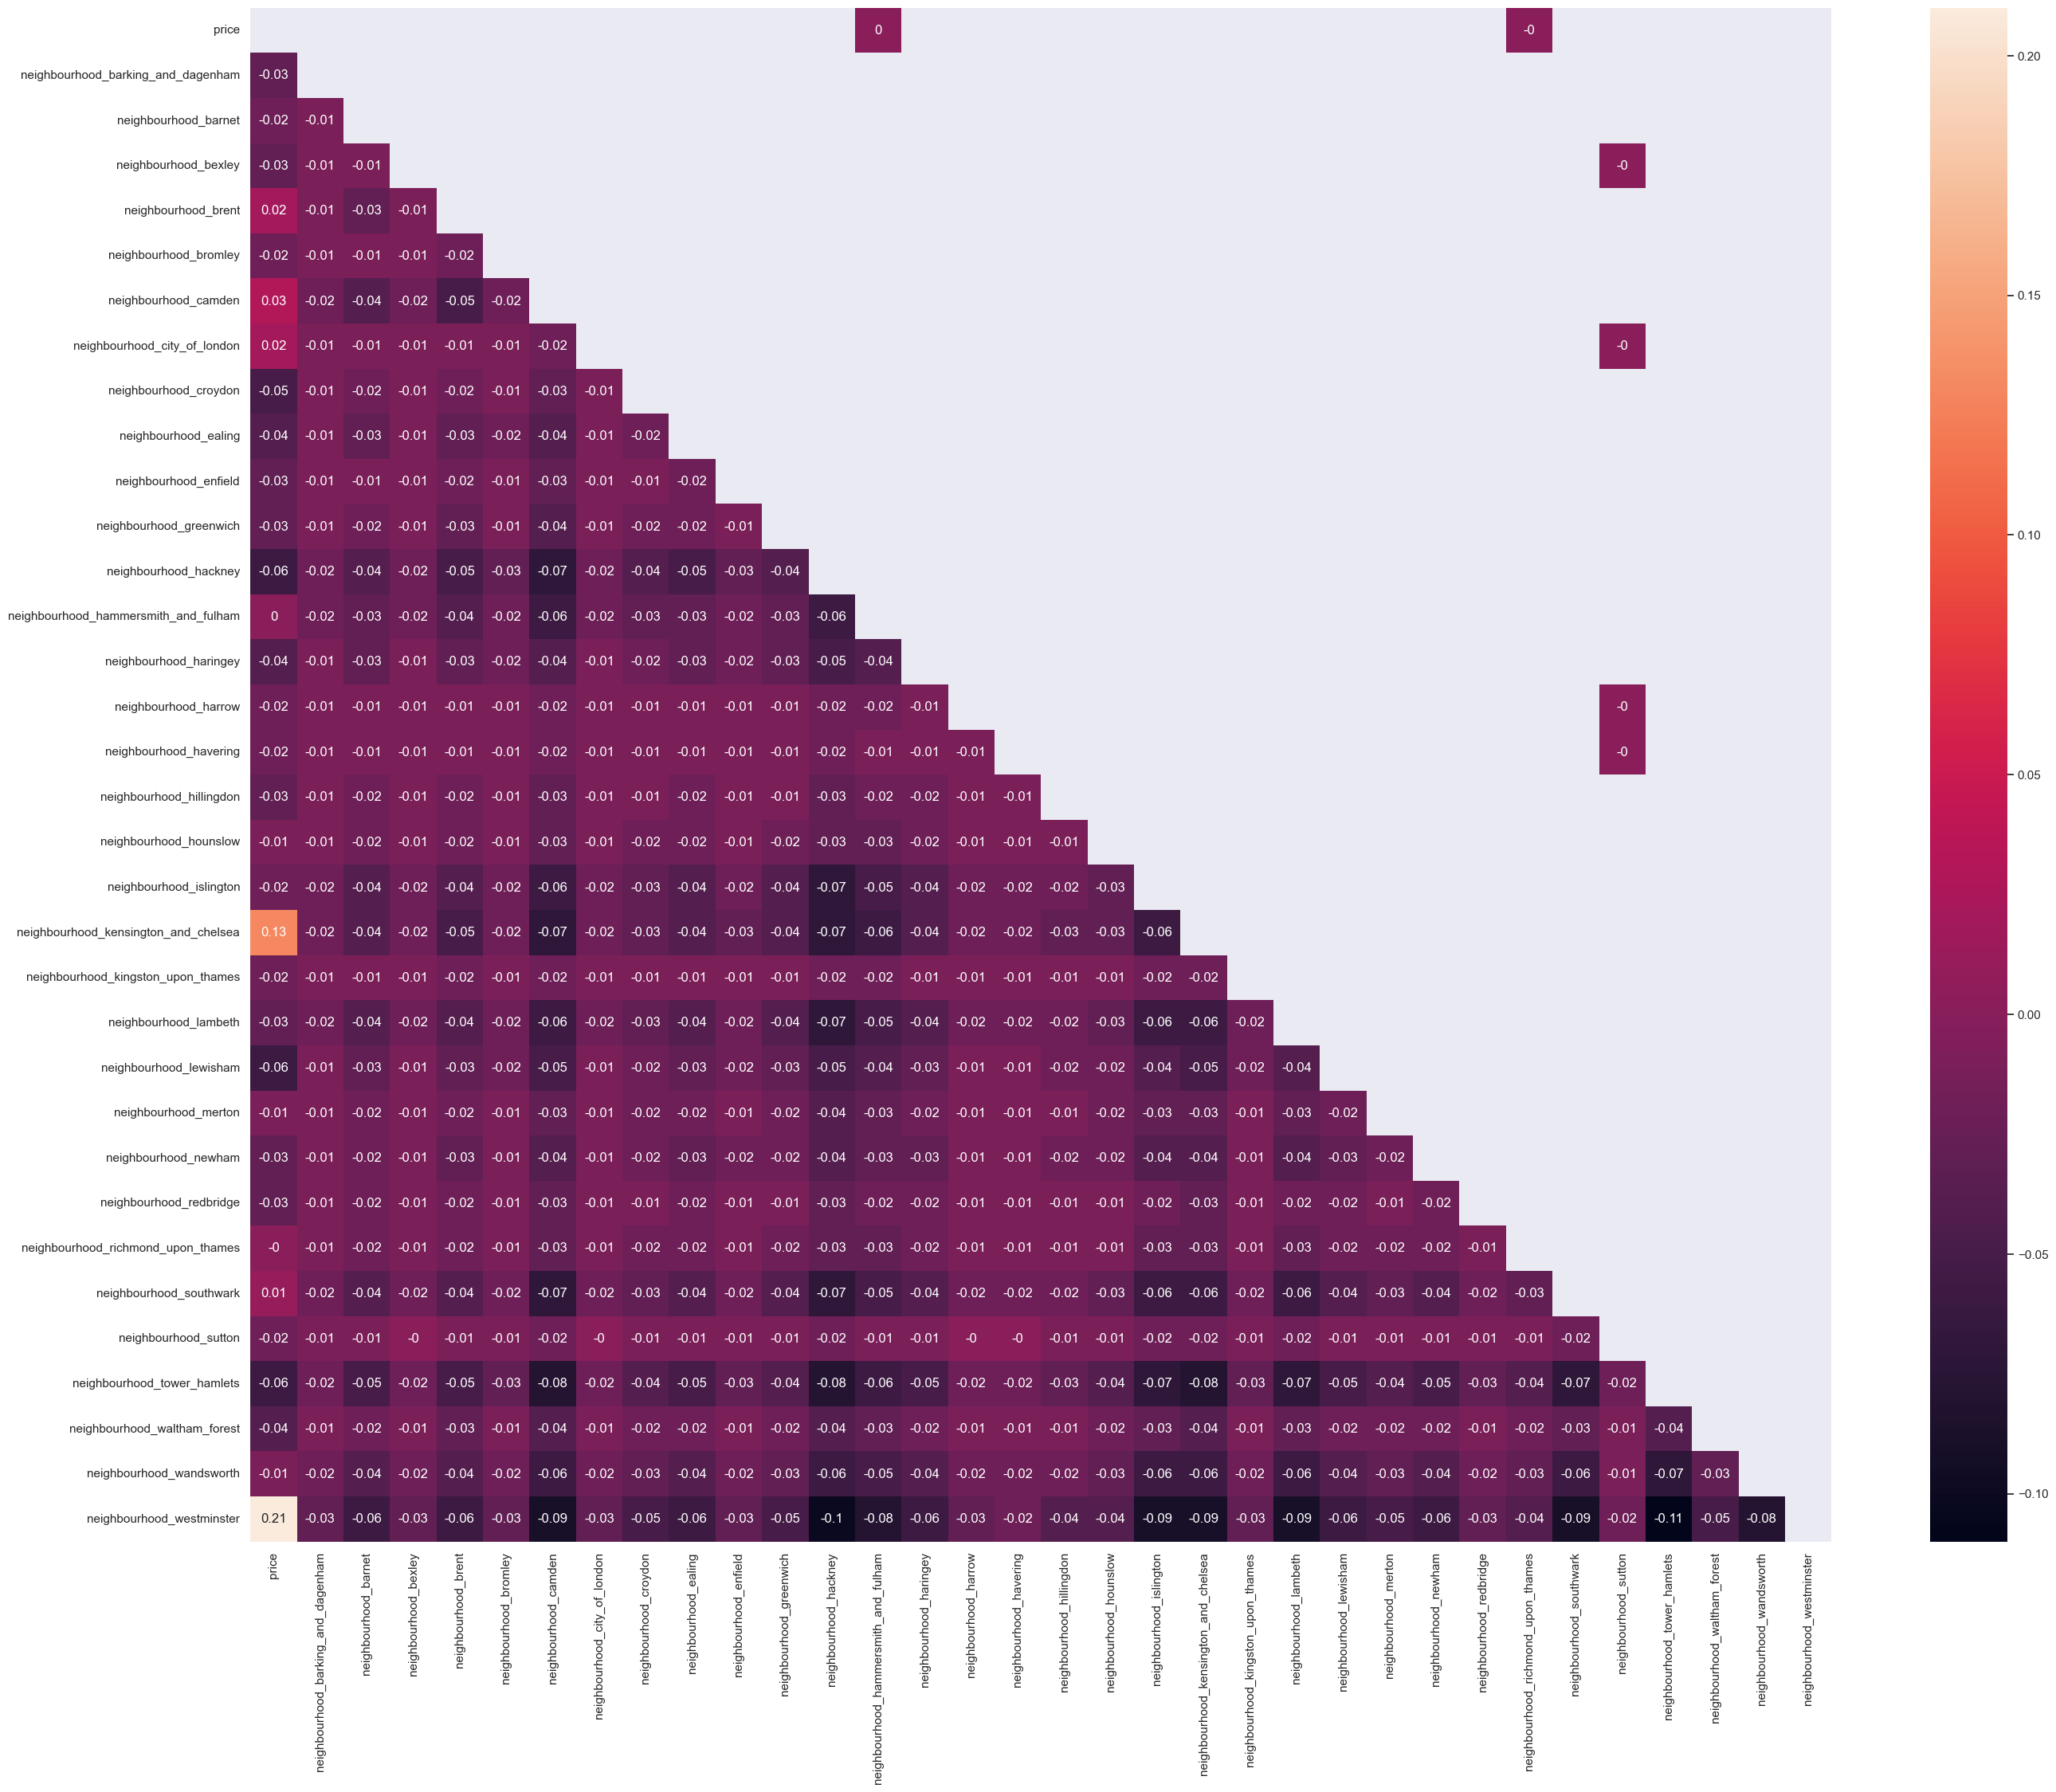

In [ ]:
corr = round(df_borough.corr(numeric_only=True),2)

sns.set(rc={"figure.figsize":(32, 25)})

# getting the upper triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

<AxesSubplot: >

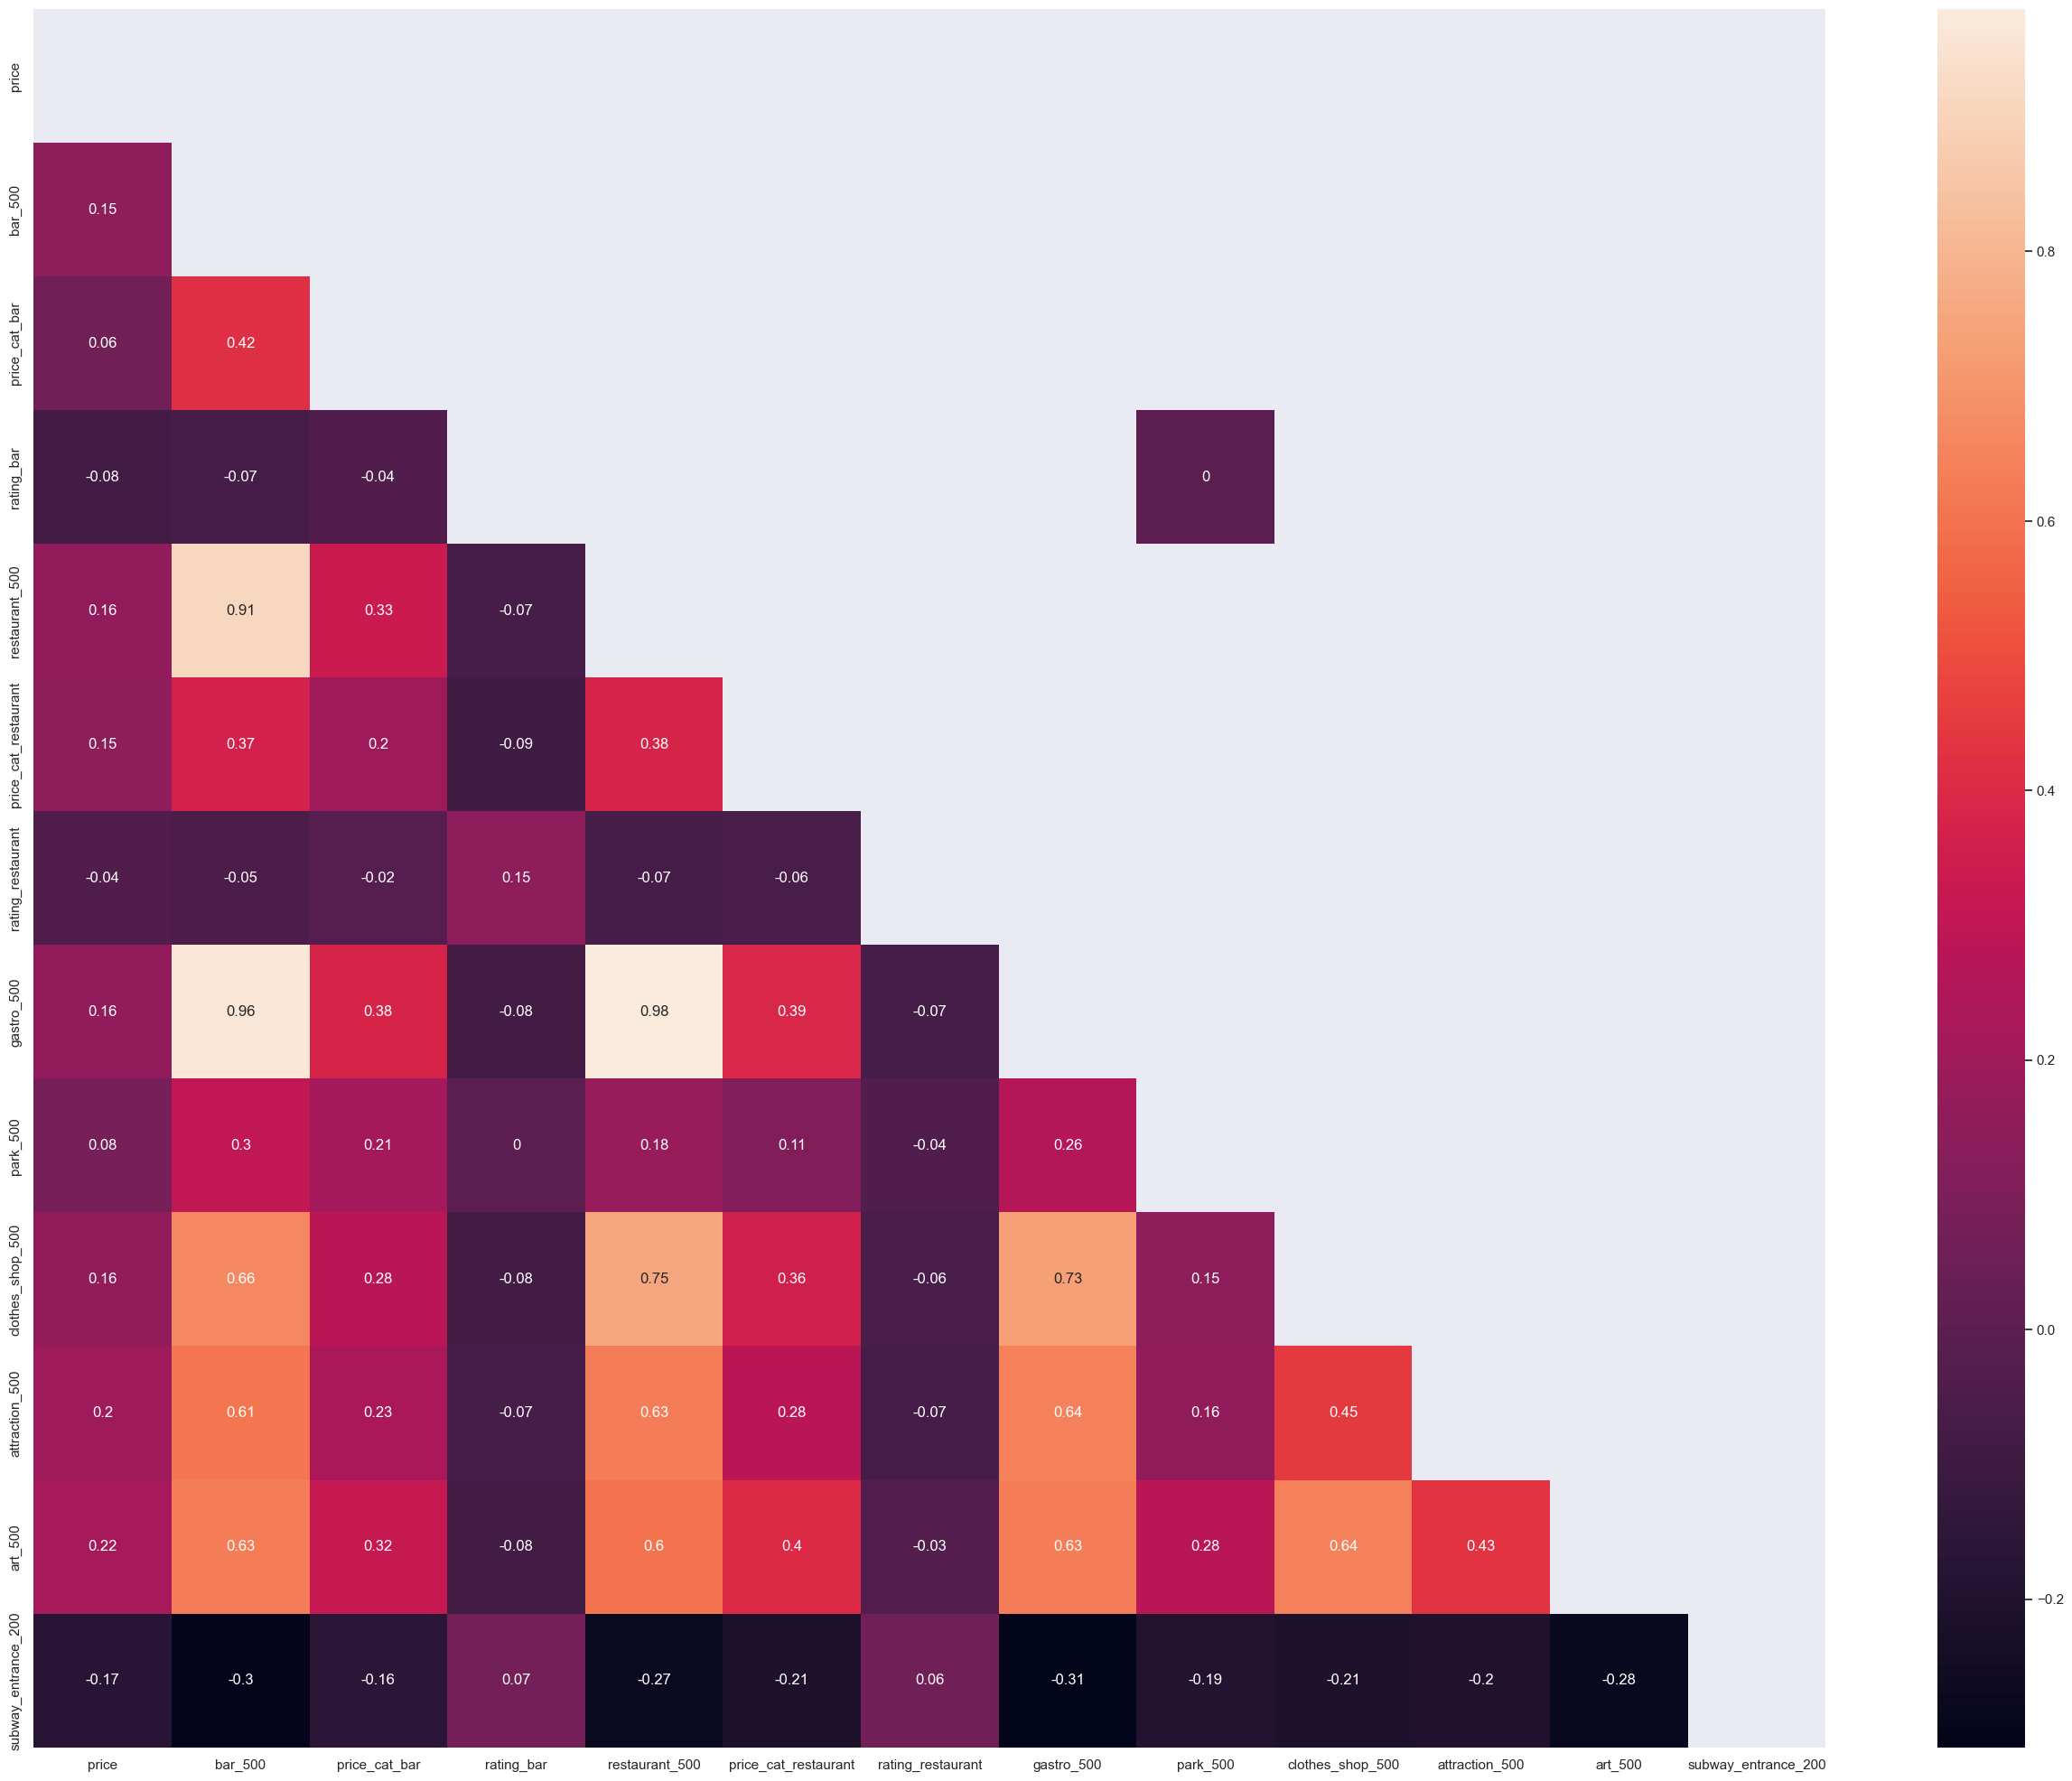

In [ ]:
corr = round(df_poi.corr(numeric_only=True),2)

sns.set(rc={"figure.figsize":(32, 25)})

# getting the upper triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

<AxesSubplot: >

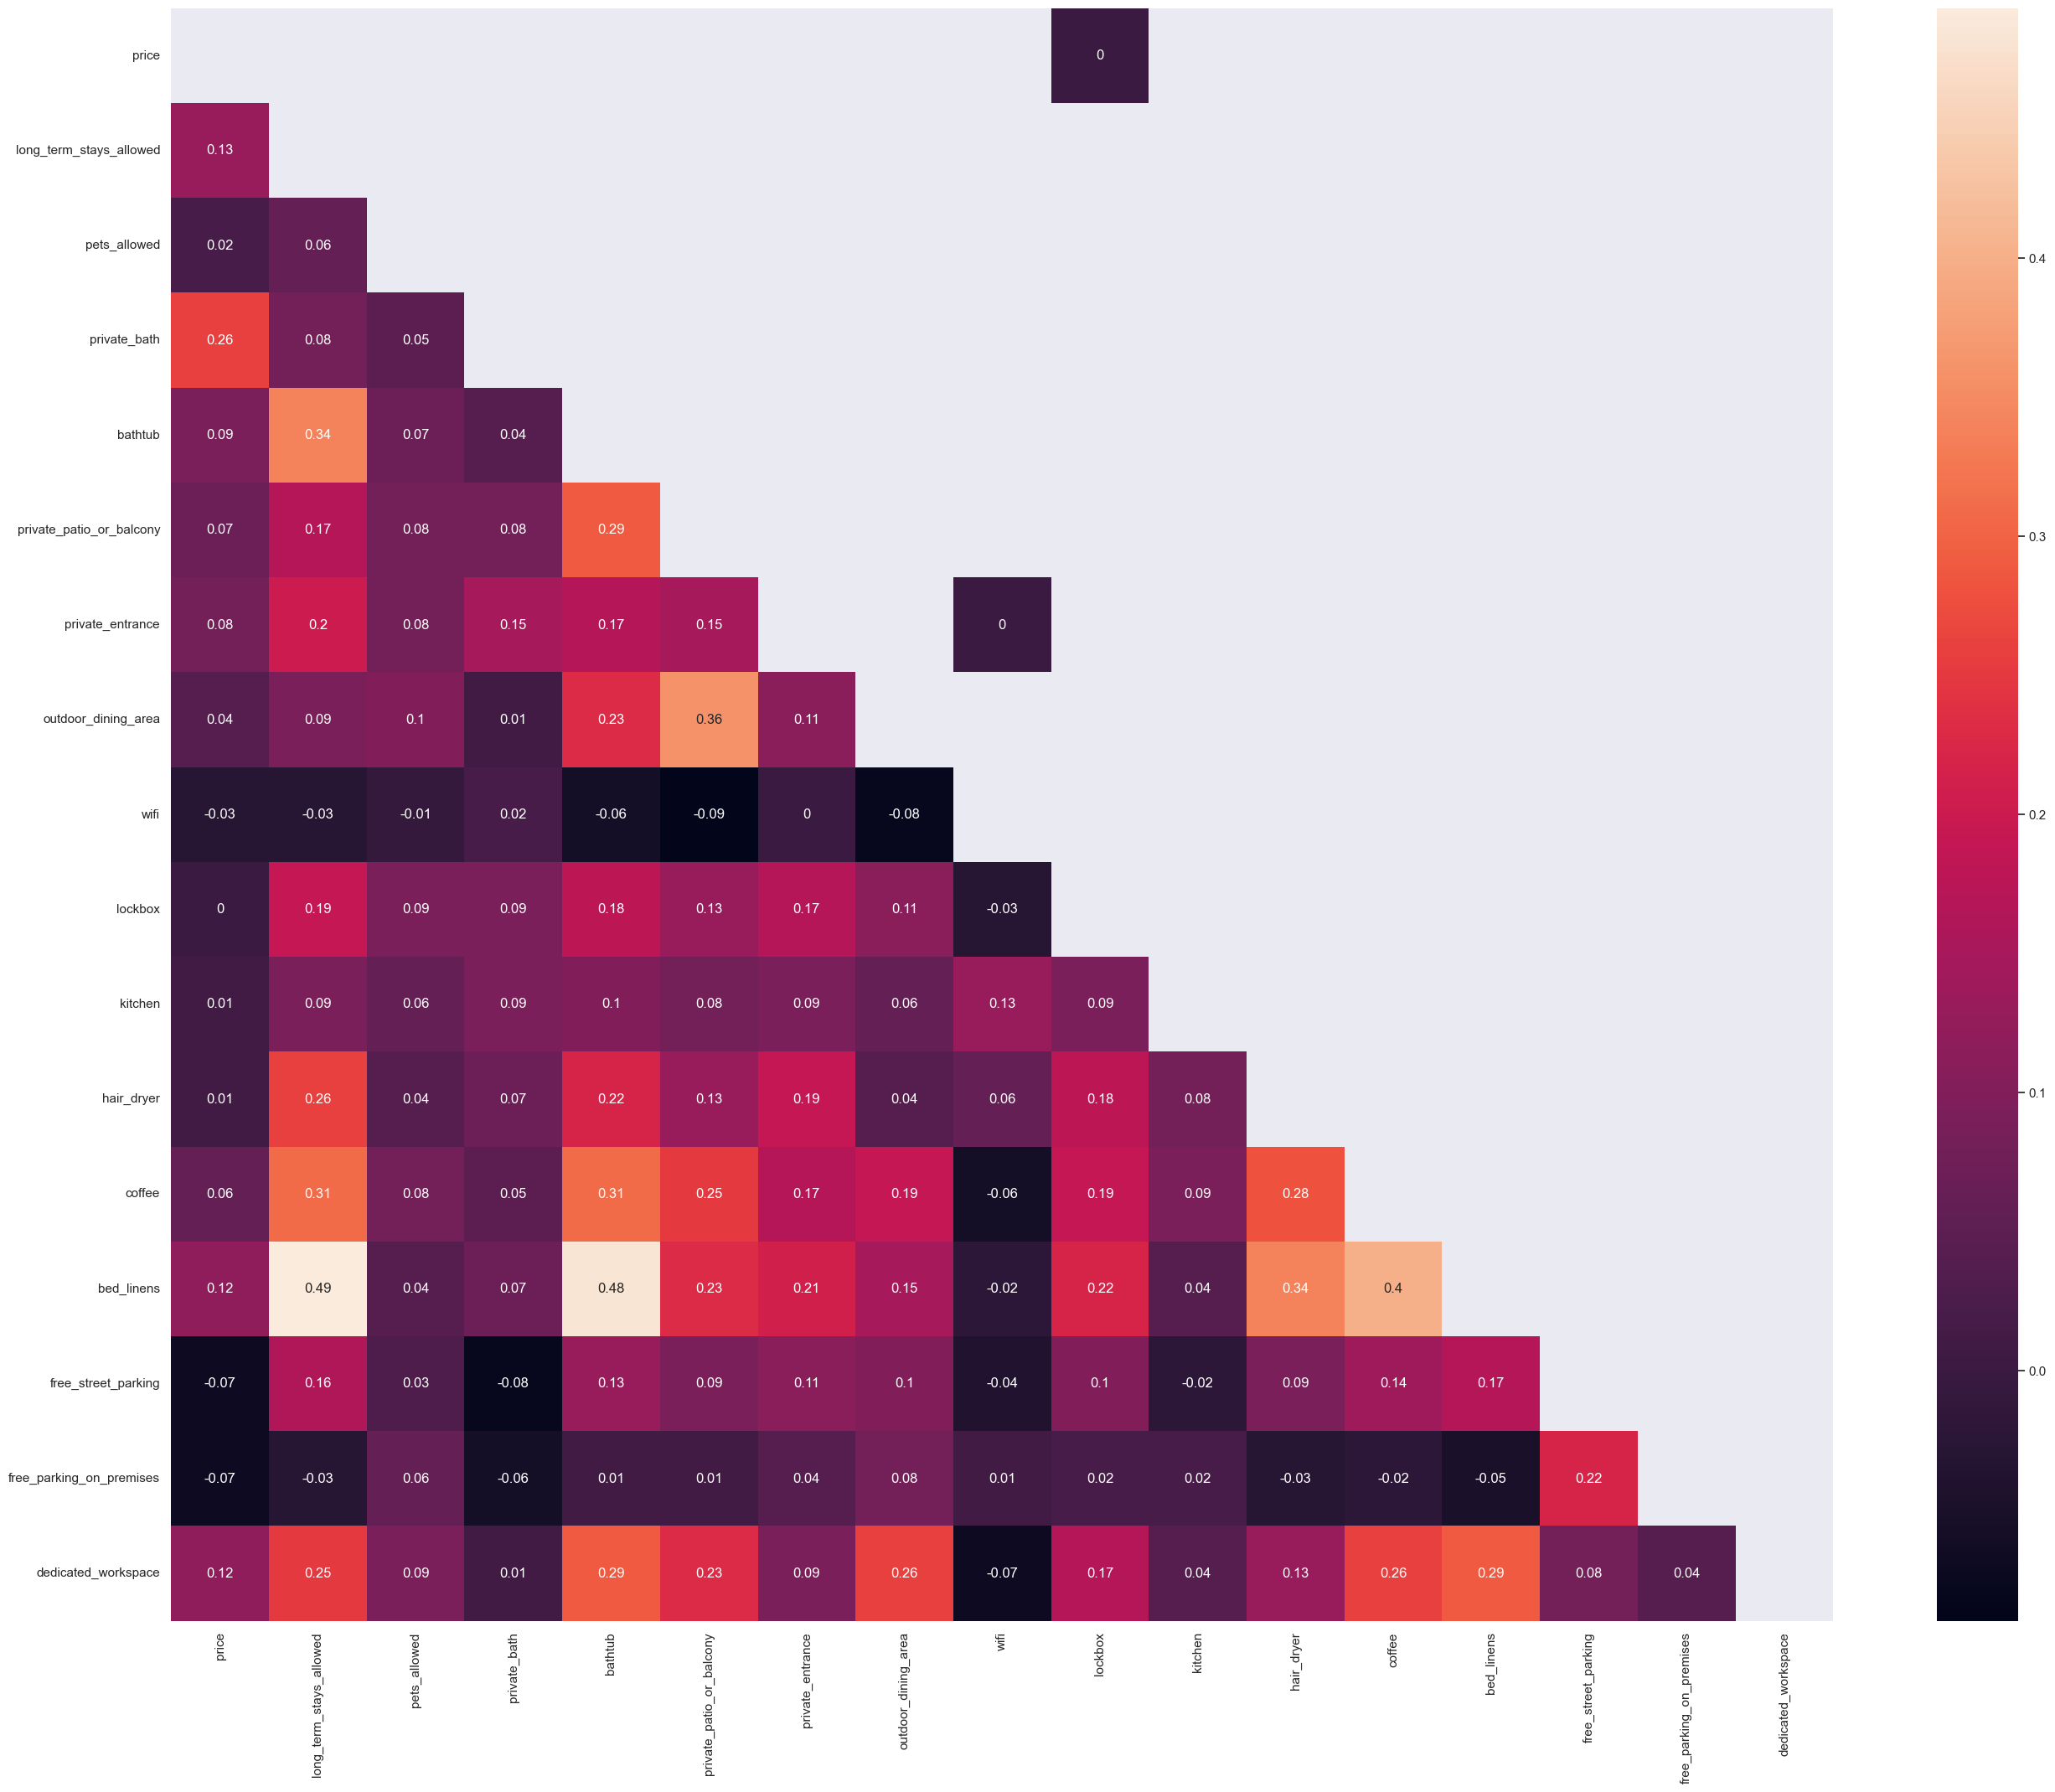

In [ ]:
corr = round(df_amm.corr(numeric_only=True),2)

sns.set(rc={"figure.figsize":(32, 25)})

# getting the upper triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

<AxesSubplot: >

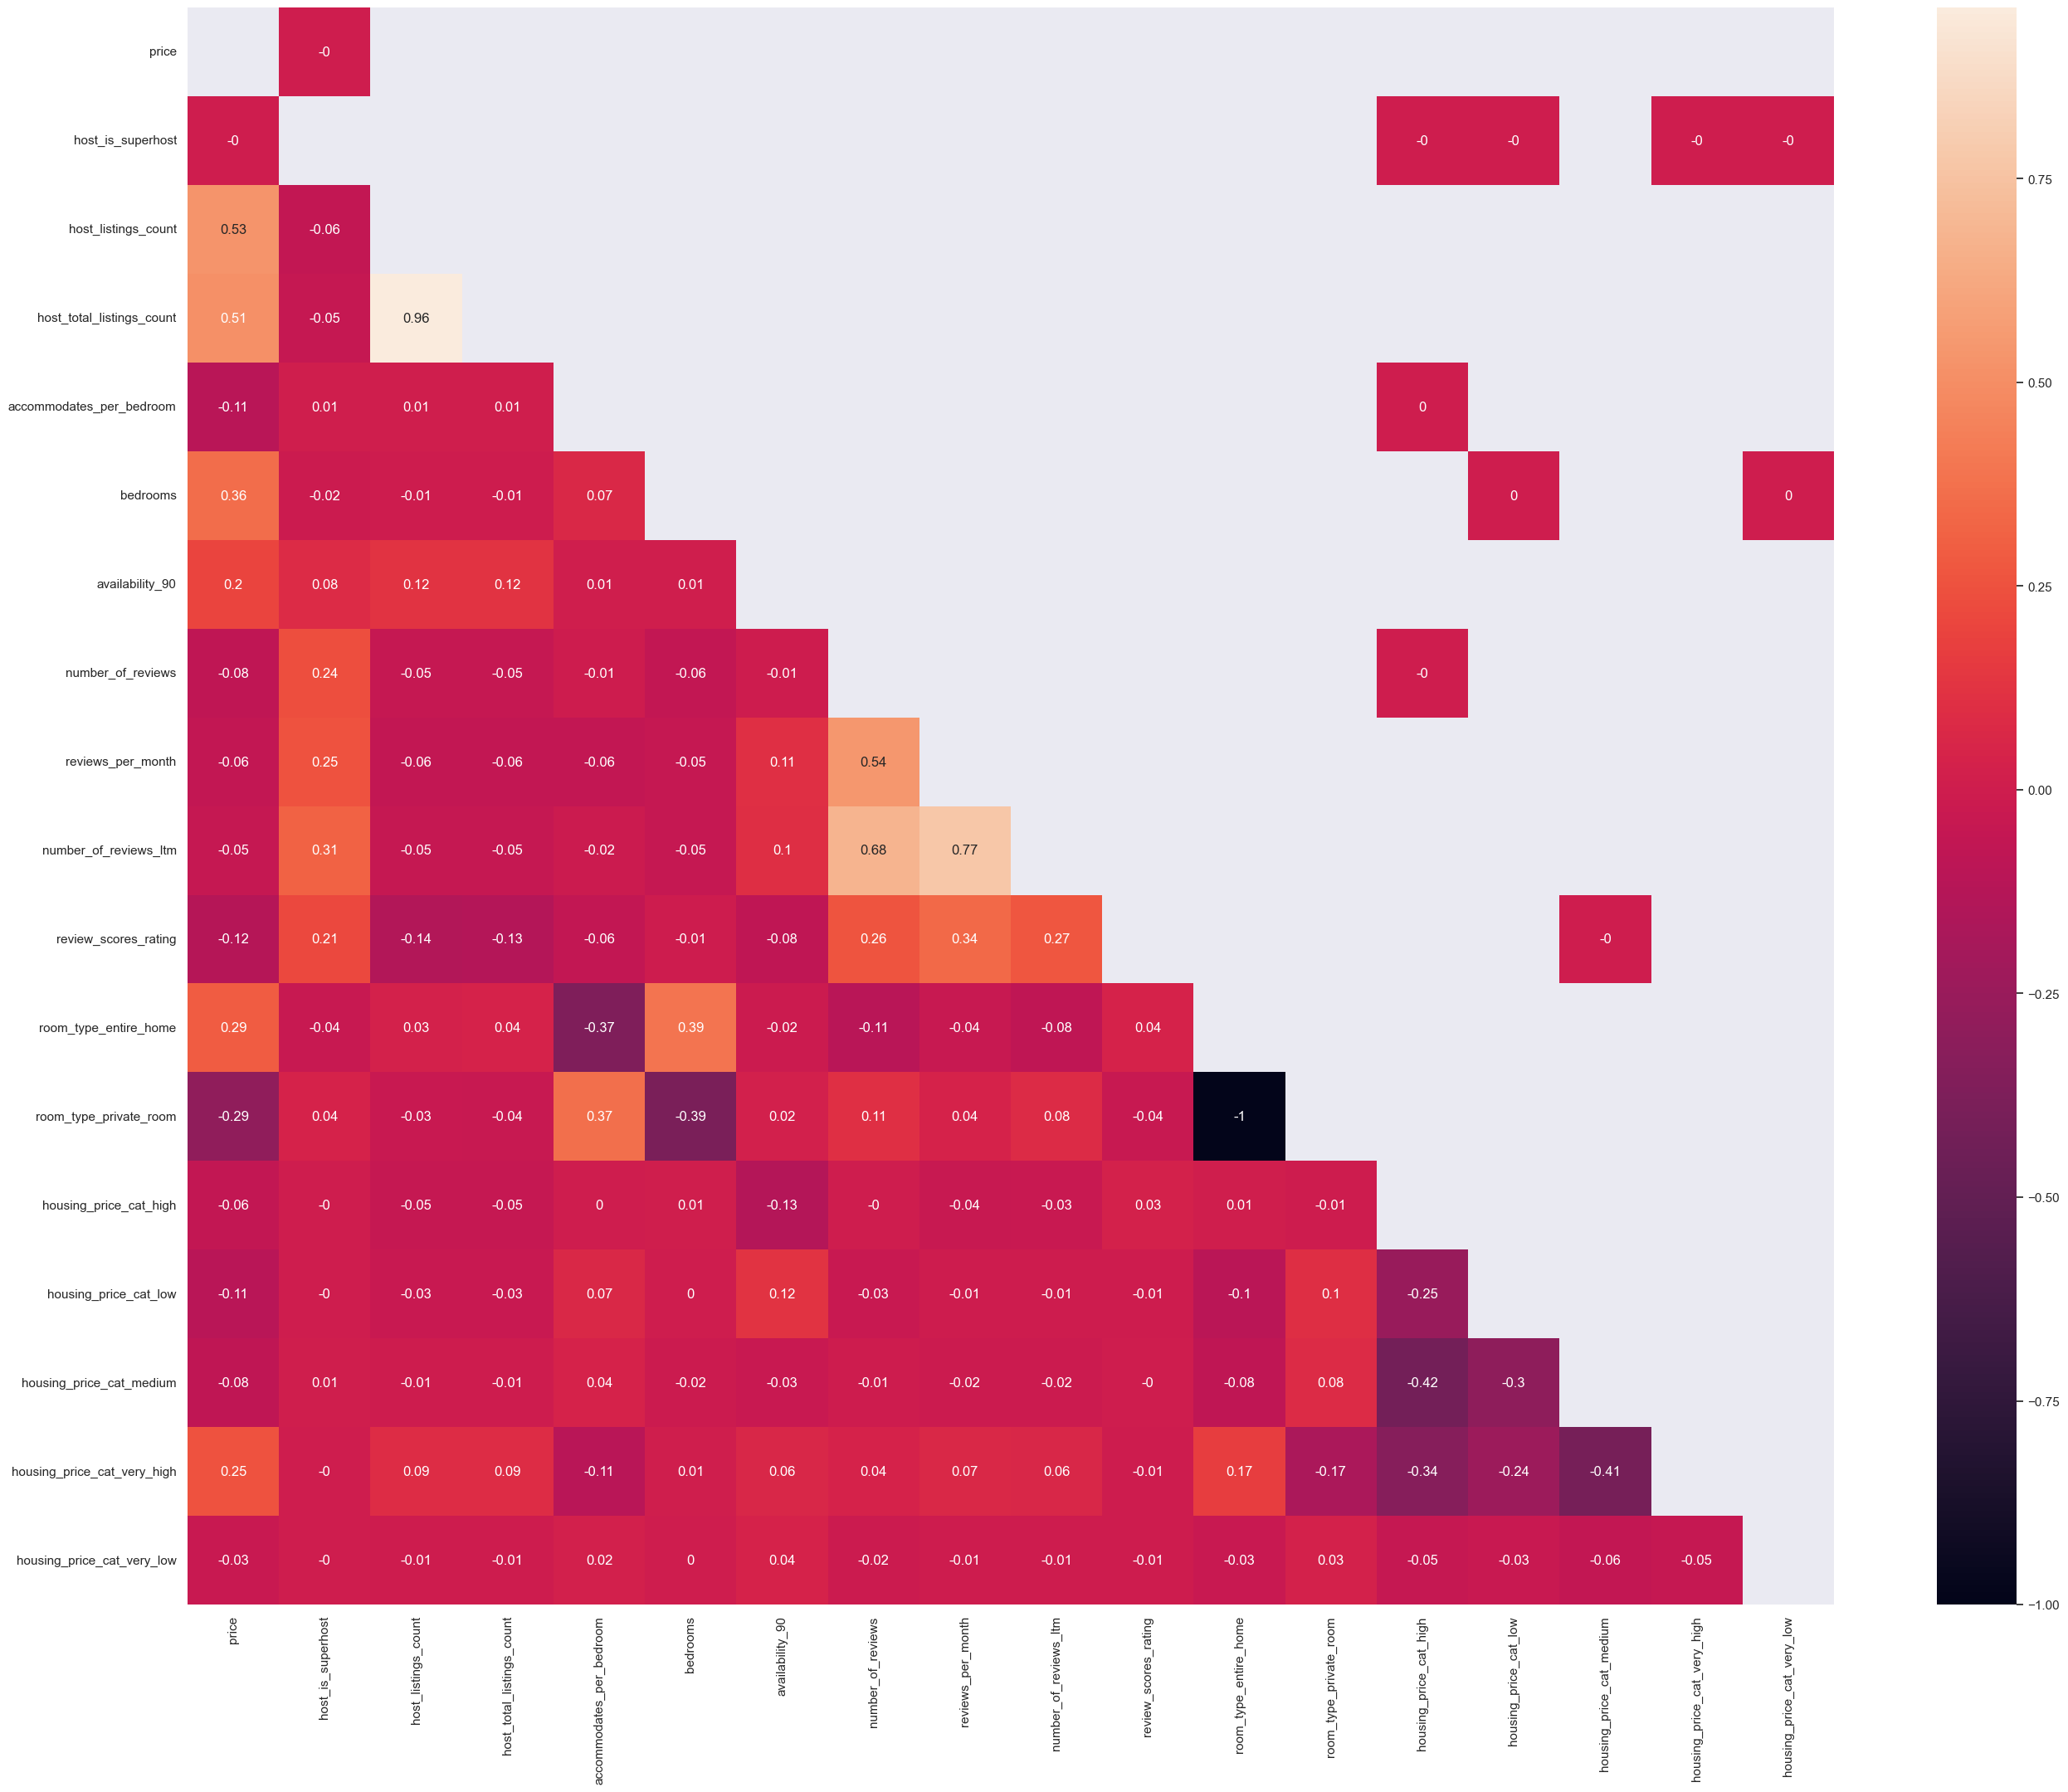

In [ ]:
corr = round(df_basic.corr(numeric_only=True),2)

sns.set(rc={"figure.figsize":(32, 25)})

# getting the upper triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

### define predicted columns

In [ ]:
pred = ["id", "price",
        "private_bath",
        "host_listings_count",
        "review_scores_rating",
        "bedrooms",
        "accommodates_per_bedroom",
        "availability_90",
        "bathtub",
        "room_type_private_room",
        "restaurant_500",
        "price_cat_restaurant",
        "clothes_shop_500",
        "attraction_500",
        "subway_entrance_200",
        "art_500",
        "housing_price_cat_very_high",
        "housing_price_cat_low"]

df_pred = df[pred]


<AxesSubplot: >

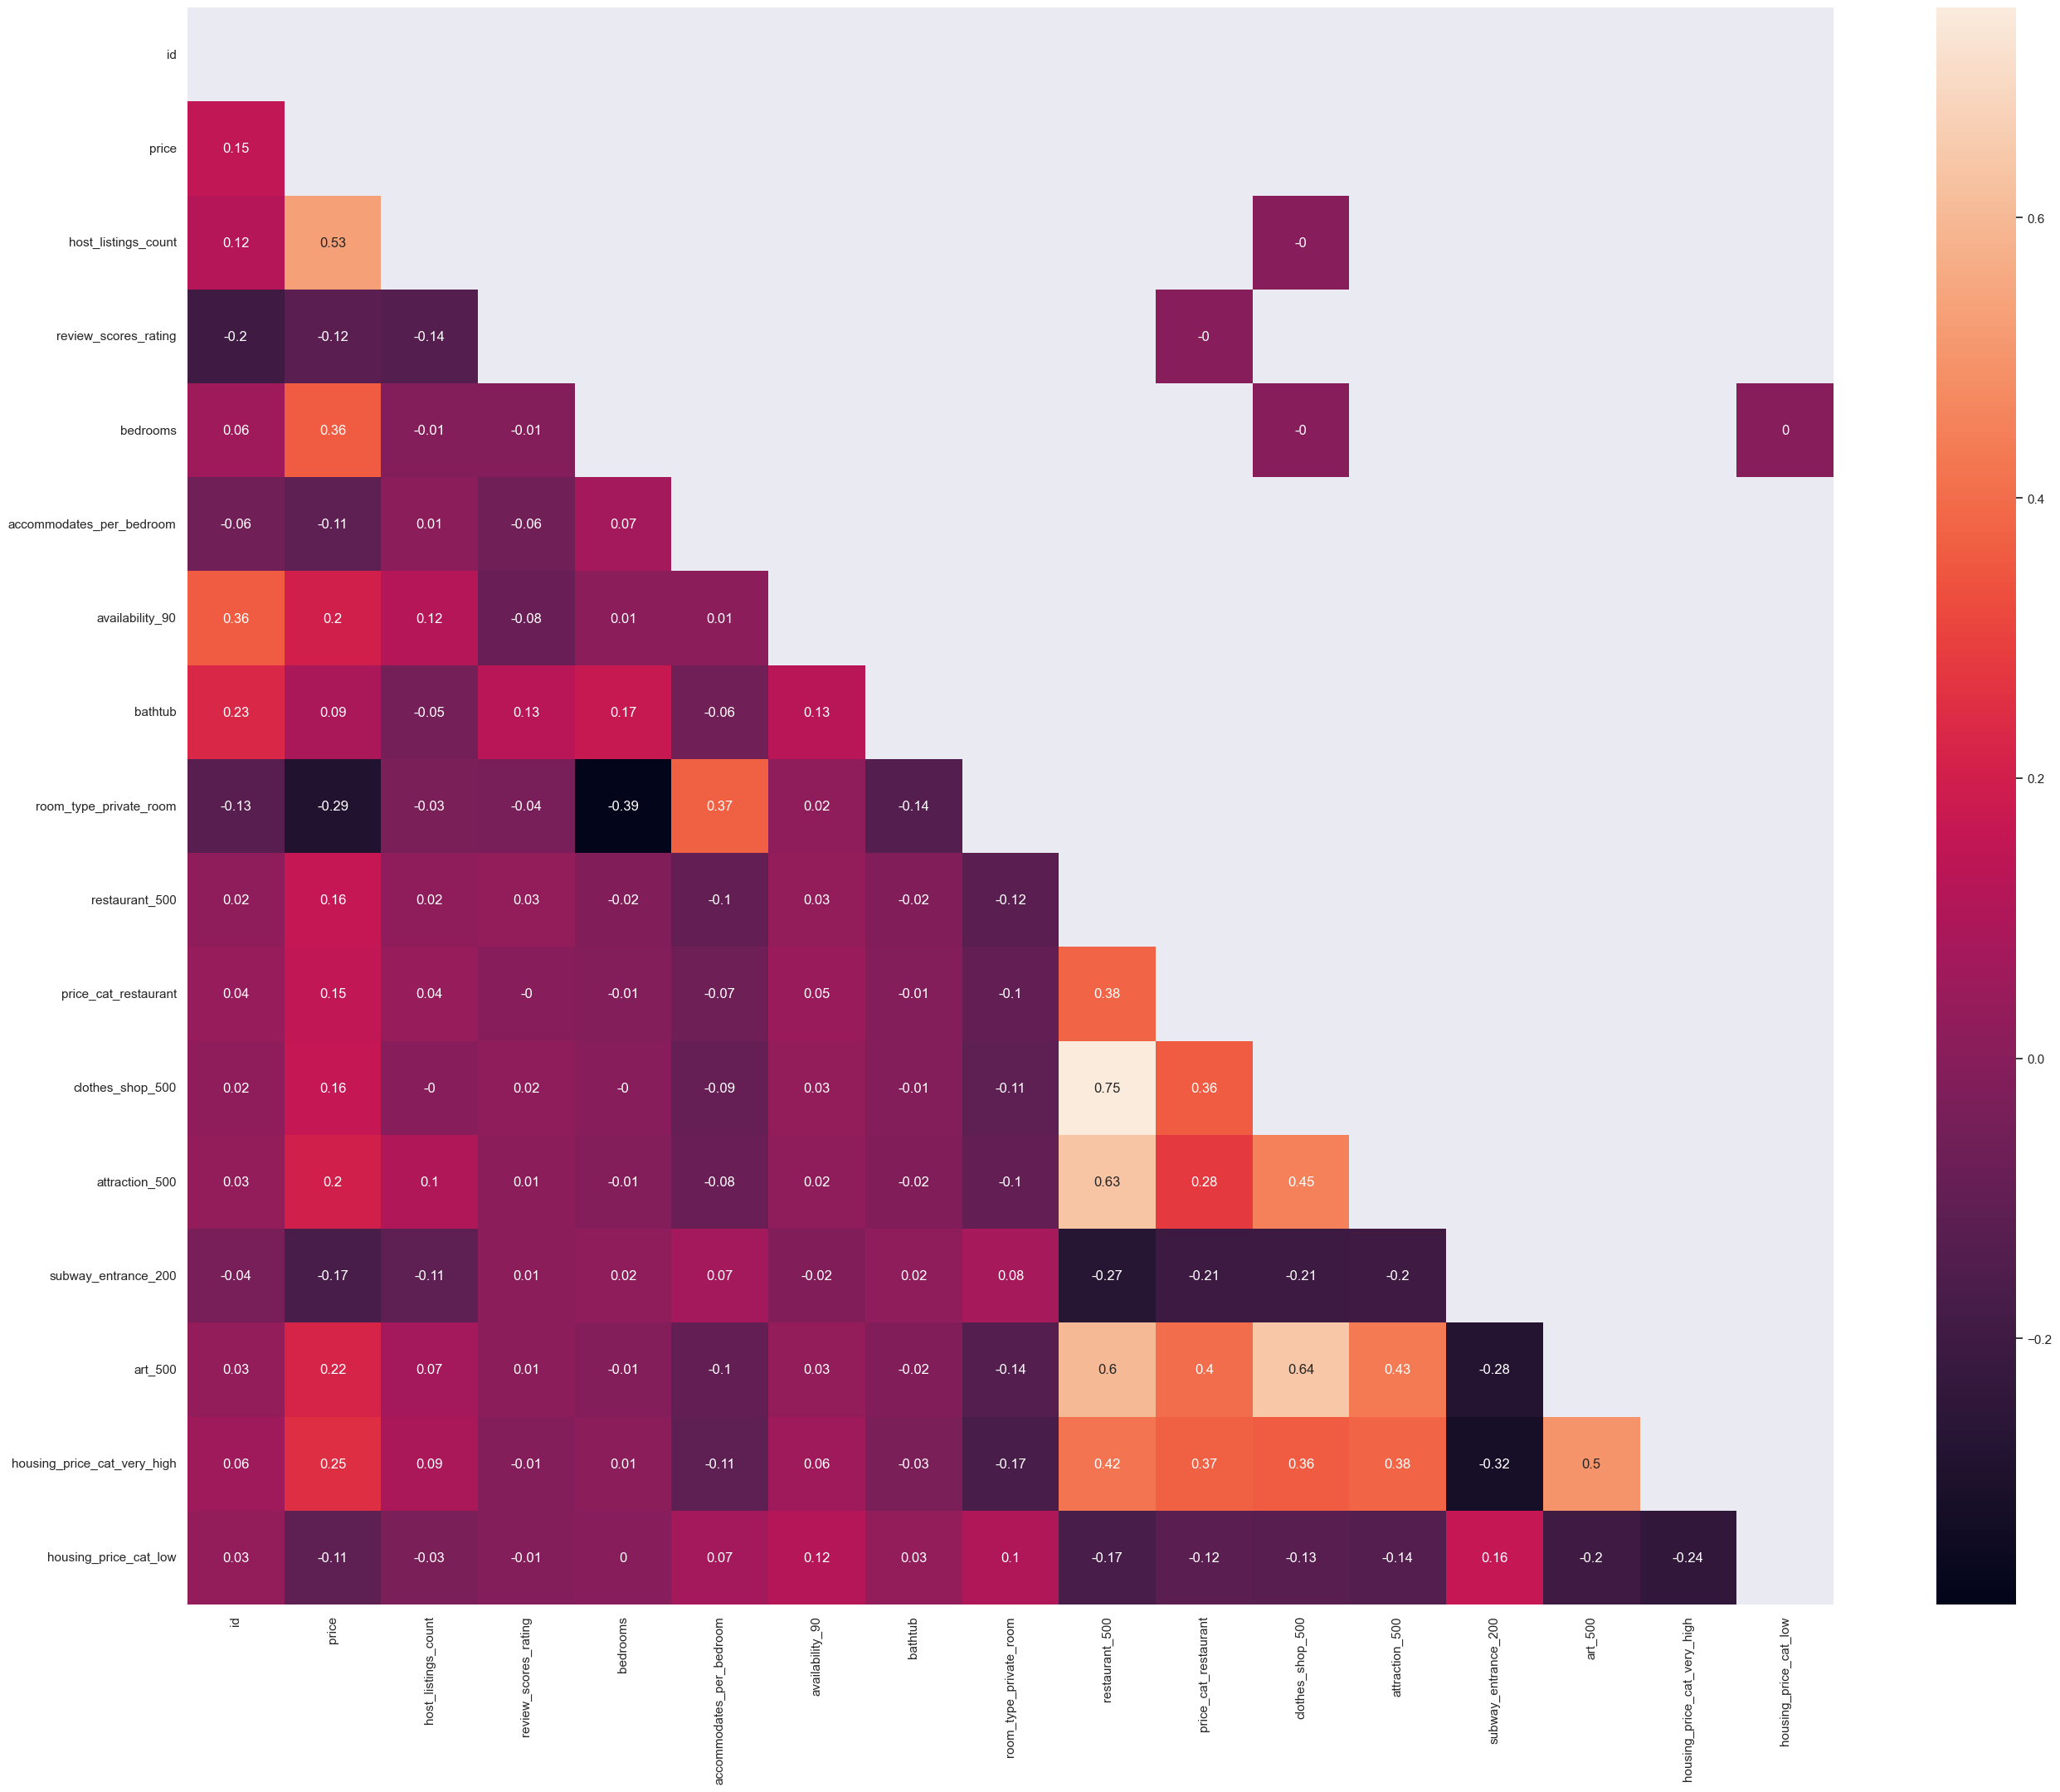

In [ ]:
corr = round(df_pred.corr(numeric_only=True),2)

sns.set(rc={"figure.figsize":(32, 25)})

# getting the upper triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### define X & y // Split Dataframe // Scale all numerical features

In [ ]:
df_pred.describe()

,id,price,host_listings_count,review_scores_rating,bedrooms,accommodates_per_bedroom,availability_90,bathtub,room_type_private_room,restaurant_500,price_cat_restaurant,clothes_shop_500,attraction_500,subway_entrance_200,art_500,housing_price_cat_very_high,housing_price_cat_low
count,7.420000e+04,74200.000000,74200.000000,74200.000000,74200.000000,74200.000000,74200.000000,74200.000000,74200.000000,74200.000000,7.420000e+04,74200.000000,74200.000000,74200.000000,74200.000000,74200.000000,74200.000000
mean,2.378833e+17,156.766658,37.108073,3.459098,1.485000,0.545732,27.079569,0.273895,0.387911,23.979205,7.832425e+08,9.674367,0.674084,0.809407,1.429650,0.248868,0.149447
std,3.430827e+17,194.404180,214.155444,2.090364,0.857581,0.260223,32.636953,0.445959,0.487277,48.563368,8.506944e+08,26.677595,1.782260,0.392771,2.678526,0.432360,0.356531
min,1.391300e+04,0.000000,1.000000,0.000000,1.000000,0.062500,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.978801e+07,60.000000,1.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,3.000000,2.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,3.943935e+07,100.000000,2.000000,4.670000,1.000000,0.500000,9.000000,0.000000,0.000000,10.000000,7.832425e+08,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,6.579544e+17,179.000000,5.000000,4.950000,2.000000,0.500000,54.000000,1.000000,1.000000,26.000000,1.666667e+09,5.000000,1.000000,1.000000,2.000000,0.000000,0.000000
max,8.463271e+17,1637.000000,2138.000000,5.000000,22.000000,11.000000,90.000000,1.000000,1.000000,483.000000,3.714286e+09,355.000000,33.000000,1.000000,30.000000,1.000000,1.000000


In [ ]:
X = df_pred.drop(["id", "price"], axis=1)
y = df_pred["price"]

# Identify numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns

# Scale numeric columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### targeting multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# create a new dataframe with only the predictor variables
#X = df_pred[columns_to_calc]
X = df_pred.drop(["id", "price"], axis=1)

# calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["predictor"] = X.columns

print(vif)


    VIF Factor                    predictor
0     1.083982          host_listings_count
1     3.260329         review_scores_rating
2     4.322197                     bedrooms
3     5.943276     accommodates_per_bedroom
4     1.758866              availability_90
5     1.491049                      bathtub
6     2.320432       room_type_private_room
7     3.878998               restaurant_500
8     2.300651         price_cat_restaurant
9     3.016641             clothes_shop_500
10    1.975113               attraction_500
11    4.392129          subway_entrance_200
12    2.691976                      art_500
13    2.017909  housing_price_cat_very_high
14    1.298861        housing_price_cat_low


### linear regression

In [ ]:
# Import the statsmodels module
import statsmodels.api as sm

# Choose the predictor X and add a constant term
X2 = df_pred.drop(["id", "price"], axis=1)
X2 = sm.add_constant(X)
# Define dependent variable
y = df_pred["price"]

# fit model and get model summery in one step
sm.OLS(y, X2).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     5169.
Date:                Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                        10:27:16   Log-Likelihood:            -4.6977e+05
No. Observations:               74200   AIC:                         9.396e+05
Df Residuals:                   74184   BIC:                         9.397e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          62.7482      2.261     27.747      0.000      58.316      67.181
host_listings_count             0.4493      0.002    186.712      0.000       0.445       0.454
review_scores_rating           -4.8210      0.245    -19.711      0.000      -5.300      -4.342
bedrooms                       74.5513      0.660    112.946      0.000      73.258      75.845
accommodates_per_bedroom      -58.8872      2.135    -27.585      0.000     -63.071     -54.703
availability_90                 0.7447      0.016     47.133      0.000       0.714       0.776
bathtub                        19.4874      1.166     16.714      0.000      17.202      21.773
room_type_private_room        -32.4532      1.253    -25.904      0.000     -34.909     -29.998
restaurant_500                 -0.1116      0.018     -6.123      0.000      -0.147      -0.076
price_cat_restaurant         4.168e-09   6.67e-10      6.245      0.000    2.86e-09    5.48e-09
clothes_shop_500                0.3545      0.031     11.586      0.000       0.295       0.414
attraction_500                  6.6255      0.368     17.997      0.000       5.904       7.347
subway_entrance_200           -21.0735      1.374    -15.339      0.000     -23.766     -18.381
art_500                         3.9636      0.271     14.642      0.000       3.433       4.494
housing_price_cat_very_high    36.5510      1.444     25.319      0.000      33.721      39.381
housing_price_cat_low         -24.4707      1.473    -16.612      0.000     -27.358     -21.583
==============================================================================
Omnibus:                    51836.739   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2376332.760
Skew:                           2.832   Prob(JB):                         0.00
Kurtosis:                      30.140   Cond. No.                     6.08e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.08e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Build the linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr.predict(X_test)

# Evaluate the performance of the linear regression model
print('Linear Regression:')
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_lr))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_lr))
print('R-squared:', r2_score(y_test, y_pred_lr))

Linear Regression:
Mean Squared Error: 18783.10820485316
Mean Absolute Error: 68.36893605597429
R-squared: 0.511487272919094


### knn model

In [ ]:
# Build the KNN model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the performance of the KNN model
print('KNN:')
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_knn))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_knn))
print('R-squared:', r2_score(y_test, y_pred_knn))

KNN:
Mean Squared Error: 13594.653118598382
Mean Absolute Error: 57.09933962264151
R-squared: 0.6464290682747863


### random forest

In [ ]:
# Import the required libraries
from sklearn.ensemble import RandomForestRegressor

# Build the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate the performance of the Random Forest model
print('Random Forest:')
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_rf))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_rf))
print('R-squared:', r2_score(y_test, y_pred_rf))

Random Forest:
Mean Squared Error: 9964.880008606558
Mean Absolute Error: 50.92349953728242
R-squared: 0.7408325259617783


### random forest on whole df

In [ ]:
# Import the required libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

# Split the data into X (independent variables) and y (dependent variable)
X = df_pred.drop(["id", "price"], axis=1)
y = df_pred["price"]

# Identify numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns

# Scale numeric columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Build the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Make predictions on the whole dataset
y_pred_rf = rf.predict(X)

# Create a new dataframe with the predicted values and the same index as df_pred
df_pred_pred = pd.DataFrame({'id': df_pred['id'], 'pred_price': y_pred_rf}, index=df_pred.index)

# Merge df_pred and df_pred_pred on the 'id' column
df_pred_with_pred = pd.merge(df_pred, df_pred_pred, on='id')

# Update df_pred to include the predicted values
df_pred = df_pred_with_pred


In [ ]:
df_pred["pred_price"] = round(df_pred["pred_price"],2)

In [ ]:
# calculate a new column to determine if the price is fair 
df_pred["fair_price"] = df_pred.apply(lambda x: "no" if x["pred_price"] < (
    x["price"] - 26) else ("yes" if x["pred_price"] > (x["price"] + 26) else "probably"), axis=1)


In [ ]:
df_pred["fair_price"].value_counts()

probably    58779
yes          8699
no           6722
Name: fair_price, dtype: int64

In [ ]:
airbnb[airbnb["id"] == 42708163]

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,availability_90,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath,wifi,long_term_stays_allowed,private_patio_or_balcony,private_entrance,pets_allowed,outdoor_dining_area,lockbox,kitchen,hair_dryer,free_street_parking,free_parking_on_premises,dedicated_workspace,coffee_,bed_linens,bathtub
19972,42708163,https://www.airbnb.com/rooms/42708163,House 6 kingsize Bedrooms free parking,https://a0.muscache.com/pictures/53117b3d-2a80...,333360192,97.0,98.0,True,4.0,5.0,Westminster,51.49632,-0.13125,Entire home,12,6.0,6.0,"[""Washer"", ""Outdoor furniture"", ""Hangers"", ""Di...",900.0,28,7,365,False,3,0,0,2020-12-07,2022-03-12,5.0,5.0,5.0,5.0,5.0,5.0,4.67,0.11,True,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1


In [ ]:
df_pred[["id","price", "pred_price", "fair_price"]].sample(20)

,id,price,pred_price,fair_price
39436,26016962,85.0,93.70,probably
29471,679026203773205644,39.0,45.40,probably
24204,52770797,45.0,44.60,probably
72730,645417792397909911,112.0,168.46,yes
64197,12105322,95.0,83.83,probably
19694,42708163,900.0,1014.34,yes
52846,51320807,120.0,116.06,probably
2429,20721031,40.0,41.22,probably
19147,23285146,48.0,51.07,probably
54883,39937529,250.0,199.38,no


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

# create a random forest regressor
rf = RandomForestRegressor()

# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# train a random forest regressor with the best hyperparameters
best_rf = RandomForestRegressor(n_estimators=best_params['n_estimators'], 
                                 max_depth=best_params['max_depth'], 
                                 max_features=best_params['max_features'])
best_rf.fit(X_train, y_train)

# evaluate the performance of the best random forest regressor on the test set
test_score = best_rf.score(X_test, y_test)
print("Test set score:", test_score)


Best hyperparameters: {'max_depth': 20, 'max_features': None, 'n_estimators': 500}
Test set score: 0.7444143745508939


### gradient boosting 

In [ ]:
# Import the required libraries
from sklearn.ensemble import GradientBoostingRegressor

# Build the Gradient Boosting model
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gbr = gbr.predict(X_test)

# Evaluate the performance of the Gradient Boosting model
print('Gradient Boosting:')
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_gbr))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_gbr))
print('R-squared:', r2_score(y_test, y_pred_gbr))


Gradient Boosting:
Mean Squared Error: 10917.711901568153
Mean Absolute Error: 53.70211864980297
R-squared: 0.7160511904445788


In [ ]:
# Check MAE and R2 for each individual column in random forest model
# # Iterate over the columns of X
# for col in X.columns:
#     # Select the current column and the target variable
#     X_col = X[[col]]
#     y = df_pred["price"]

#     # Scale the current column
#     scaler = StandardScaler()
#     X_col = scaler.fit_transform(X_col)

#     # Split the data into training and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X_col, y, test_size=0.2, random_state=42)

#     # Build the Random Forest model
#     rf = RandomForestRegressor(n_estimators=100, random_state=42)
#     rf.fit(X_train, y_train)

#     # Make predictions on the test set
#     y_pred_rf = rf.predict(X_test)

#     # Evaluate the performance of the Random Forest model
#     print(f'Column {col}:')
#     print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_rf))
#     print('R-squared:', r2_score(y_test, y_pred_rf))
#     print()


## EDA Customer oriented

###  #1: Budget Traveller: 

* Where can i find cheap Airbnb's with good (and cheap) Infrastructure?
* Only Price Category 1
* Number of POI's above average 
* Only restaurants with price category below average 


In [236]:
poi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75241 entries, 0 to 75240
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           75241 non-null  int64  
 1   listing_url                  75241 non-null  object 
 2   name                         75241 non-null  object 
 3   picture_url                  75241 non-null  object 
 4   host_id                      75241 non-null  int64  
 5   host_response_rate           46285 non-null  float64
 6   host_acceptance_rate         51028 non-null  float64
 7   host_is_superhost            75241 non-null  bool   
 8   host_listings_count          75241 non-null  float64
 9   host_total_listings_count    75241 non-null  float64
 10  neighbourhood                75241 non-null  object 
 11  avg_housing_price_22         75241 non-null  int64  
 12  latitude                     75241 non-null  float64
 13  longitude       

In [237]:
poi['price_cat_restaurant'].value_counts(dropna=False)

NaN             16689
2.000000e+00    16175
1.500000e+01     3906
1.666667e+09     3275
1.000000e+00     3037
                ...  
1.731707e+09        1
2.104294e+09        1
2.209756e+09        1
2.112676e+09        1
2.184834e+09        1
Name: price_cat_restaurant, Length: 1836, dtype: int64

In [238]:
poi.shape

(75241, 66)

In [239]:
poi_cols = ['bar_500','cafe_500', 'fast_food_500', 'restaurant_500', 'gastro_500','park_500',  'clothes_shop_500', 
        'attraction_500', 'gallery_500', 'museum_500', 'art_500','subway_entrance_500', 'subway_entrance_200']

In [259]:
poi.head()

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood,avg_housing_price_22,latitude,longitude,room_type,room_type_int,accommodates,bedrooms,beds,price,price_category,availability_90,number_of_reviews,reviews_per_month,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,long_term_stays_allowed,pets_allowed,private_bath,bathtub,private_patio_or_balcony,private_entrance,outdoor_dining_area,wifi,lockbox,kitchen,hair_dryer,coffee,bed_linens,free_street_parking,free_parking_on_premises,dedicated_workspace,bar_500,price_cat_bar,rating_bar,cafe_500,fast_food_500,restaurant_500,price_cat_restaurant,rating_restaurant,gastro_500,park_500,clothes_shop_500,attraction_500,gallery_500,museum_500,art_500,subway_entrance_500,subway_entrance_200,accommodates_per_bedroom,culture_500,going_out_500
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,600910,51.597280,-0.139330,Private room,2,1,1.0,1.0,100.0,2,90,0,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,False,0,0,0,1,0,0,0,1,0,0,0,0,0,1.0,NaN,NaN,1.0,3.0,3.0,2.0,4.70,8.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,1.0,0.0,2.0
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,595486,51.636518,-0.177475,Entire home,4,1,1.0,1.0,65.0,2,90,0,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,1.0,1.0,4.0,2.0,4.25,6.0,1.0,0.0,0.0,0.0,0.0,0.0,True,True,1.0,0.0,1.0
2,822557738577472503,https://www.airbnb.com/rooms/822557738577472503,PropertyPlug - 2Bed Flat in Edgware SmartTV WiFi,https://a0.muscache.com/pictures/d77957d5-695a...,325629338,100.0,91.0,True,4.0,8.0,Harrow,542277,51.608180,-0.277400,Entire home,4,4,2.0,2.0,132.0,3,35,0,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,True,1,1,0,0,1,0,1,1,0,1,0,1,0,3.0,2.000000e+00,3.933333,1.0,0.0,2.0,2.0,4.25,6.0,1.0,0.0,0.0,0.0,0.0,0.0,True,True,0.5,0.0,4.0
3,3518856,https://www.airbnb.com/rooms/3518856,Wimbledon Double Bedroom Ensuite,https://a0.muscache.com/pictures/23a18442-fc1d...,187811,NaN,100.0,False,2.0,5.0,Merton,594930,51.422310,-0.188410,Private room,2,1,1.0,1.0,100.0,2,90,4,0.05,0,3.67,3.0,4.33,4.67,5.0,3.67,3.67,0,0,True,0,0,0,0,1,0,1,0,0,0,0,0,1,2.0,1.500000e+01,4.500000,2.0,2.0,0.0,NaN,NaN,6.0,2.0,0.0,0.0,0.0,0.0,0.0,True,True,1.0,0.0,4.0
4,4876550,https://www.airbnb.com/rooms/4876550,Stunning Apartment 2 minutes walk to Tube Station,https://a0.muscache.com/pictures/miso/Hosting-...,25087384,75.0,46.0,False,1.0,1.0,Barnet,595486,51.602282,-0.193606,Entire home,4,2,1.0,1.0,120.0,3,83,0,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,True,0,0,0,0,1,0,1,0,0,0,0,1,0,4.0,1.666667e+09,4.225000,4.0,1.0,3.0,2.0,3.90,12.0,3.0,0.0,0.0,0.0,0.0,0.0,True,True,0.5,0.0,8.0


In [284]:
testi = poi.groupby('neighbourhood')['review_scores_rating'].mean().sort_values()
print(testi)

neighbourhood
Hillingdon                4.464325
Harrow                    4.500714
City of London            4.508802
Newham                    4.519707
Tower Hamlets             4.528006
Hounslow                  4.530396
Westminster               4.537919
Redbridge                 4.542748
Camden                    4.546306
Barking and Dagenham      4.554371
Kensington and Chelsea    4.555669
Islington                 4.569309
Brent                     4.574306
Ealing                    4.581910
Hammersmith and Fulham    4.583389
Barnet                    4.586087
Greenwich                 4.586765
Enfield                   4.598737
Bexley                    4.614585
Southwark                 4.616410
Croydon                   4.618736
Lewisham                  4.622040
Havering                  4.629458
Wandsworth                4.634352
Haringey                  4.642196
Lambeth                   4.653908
Merton                    4.654343
Hackney                   4.657234
Sutton

In [285]:

a = testi.at['Hackney']
print(a)

4.657234393404004


In [240]:
# Filter only Airbnb's where the amount of POI's is above the average +
# the Price Category of the Airnbnb is 1 + the Price Category of Restaurants is below average 

# Filter out rows where price_cat_restaurant is NaN
budget_poi = poi[~poi['price_cat_restaurant'].isna()]

# calculate the mean of each column
mean_values = budget_poi[['bar_500', 'cafe_500', 'fast_food_500', 'restaurant_500', 'gastro_500', 'park_500',
                   'clothes_shop_500', 'attraction_500', 'gallery_500', 'museum_500', 'art_500']].mean()

# create a boolean mask based on the mean values and the price category conditions
mask = ((budget_poi[['bar_500', 'cafe_500', 'fast_food_500', 'restaurant_500', 'gastro_500', 'park_500',
              'clothes_shop_500', 'attraction_500', 'gallery_500', 'museum_500', 'art_500']] > mean_values).any(axis=1)) & \
    (budget_poi['price_category'] == 1) & \
    (budget_poi['price_cat_restaurant'] < budget_poi['price_cat_restaurant'].mean())

# filter the dataframe using the boolean mask
budget_poi = budget_poi.loc[mask]

In [241]:
budget_poi.shape

(5316, 66)

In [242]:
# group by neighbourhood and calculate the mean number of POI's + Total Number of Airbnb's  
budget_grouped = budget_poi.groupby(by="neighbourhood").agg(count=("id", "size"),
                                                       gastro_mean=("gastro_500", "mean"),
                                                       price_cat_restaurant_mean=("price_cat_restaurant", "mean"),
                                                       clothes_shop_mean=("clothes_shop_500", "mean"),
                                                       attraction_mean=("attraction_500", "mean"),
                                                       art_mean=("art_500", "mean")).reset_index(level=None)


In [243]:
# calculate the same for all Airbnb's, in order to then calculate the % of Budget friendly Airbnbs 
grouped = poi.groupby(by="neighbourhood").agg(count=("id", "size"),
                                               gastro_mean=("gastro_500", "mean"),
                                               price_cat_restaurant_mean=("price_cat_restaurant", "mean"),
                                               clothes_shop_mean=("clothes_shop_500", "mean"),
                                               attraction_mean=("attraction_500", "mean"),
                                               art_mean=("art_500", "mean")).reset_index(level=None)


In [244]:
grouped.columns

Index(['neighbourhood', 'count', 'gastro_mean', 'price_cat_restaurant_mean',
       'clothes_shop_mean', 'attraction_mean', 'art_mean'],
      dtype='object')

In [245]:
# Calculate percentage of count
budget_grouped['count_percentage'] = budget_grouped['count'] / grouped.loc[grouped['neighbourhood'].isin(budget_grouped['neighbourhood']), 'count'].values * 100
# round 
budget_grouped['count_percentage'] = round(budget_grouped['count_percentage'],1)

# Select only 'count' and 'count_percentage' columns
count_df = budget_grouped[['count', 'count_percentage']]

# Concatenate the two dataframes vertically
budget_result = pd.concat([count_df, budget_grouped.drop(
    columns=['count', 'count_percentage'])], axis=1)
budget_result = result[['neighbourhood', 'count', 'count_percentage', 'gastro_mean',
                 'price_cat_restaurant_mean', 'clothes_shop_mean', 'attraction_mean', 'art_mean']].sort_values(by="count", ascending=False)


NameError: name 'result' is not defined

In [246]:
# create a df to plot only the neighbourhoods with the most Airbnbs for this filter, and only the number of of Airbnbs + % 
plotting = budget_result[["neighbourhood", "count", "count_percentage"]].head(11)
# Set the neighbourhood column as the index
plotting = plotting.set_index('neighbourhood')


/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/3871107668.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(plotting.index, rotation=45)


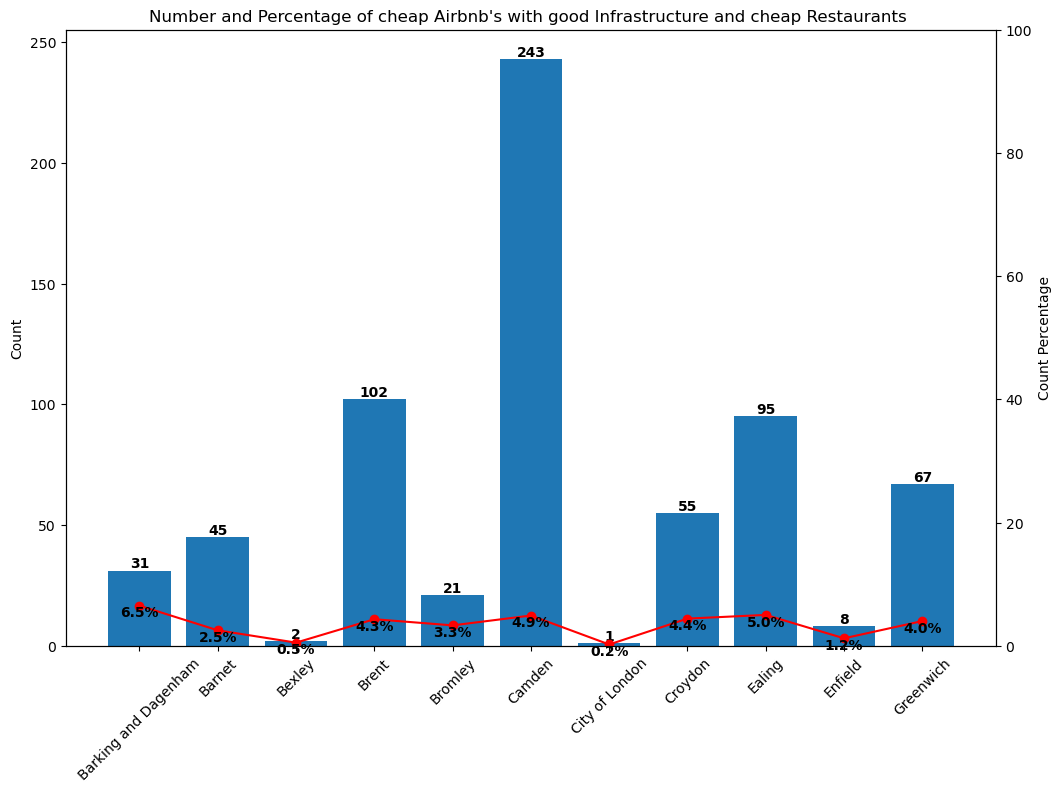

In [247]:
import matplotlib.pyplot as plt

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create bar chart for count column
ax1.bar(plotting.index, plotting['count'])
ax1.set_ylabel('Count')
ax1.set_xticklabels(plotting.index, rotation=45)

# Create secondary axis for count_percentage column
ax2 = ax1.twinx()
ax2.plot(plotting.index, plotting['count_percentage'], color='red', marker='o')
ax2.set_ylim(0, 100)
ax2.set_ylabel('Count Percentage')

# Add count values inside bars
for i, val in enumerate(plotting['count']):
    ax1.text(i, val, str(val), ha='center', va='bottom', fontweight='bold')

# Add count_percentage values inside line plot
for i, val in enumerate(plotting['count_percentage']):
    ax2.text(i, val, f"{val:.1f}%", ha='center', va='top', fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)


plt.title("Number and Percentage of cheap Airbnb's with good Infrastructure and cheap Restaurants ")
# Show the plot
plt.show();


### #2 Luxury Traveller

Where can i find the "best" Airbnb's: 
* high price-category (3+4)
* high rating: 4,5+ 
* more than average poi's 

In [248]:
# Filter only Airbnb's where the amount of POI's is above the average +
# the Price Category of the Airnbnb is 3 or 4 + the Price Category of Restaurants is above average + 
# rating of airbnb is 4.5+ 

# Filter out rows where price_cat_restaurant or review_scores_rating is NaN
luxury_poi = poi[~poi['price_cat_restaurant'].isna()]
luxury_poi = poi[~poi['review_scores_rating'].isna()]

# calculate the mean of each column
mean_values = luxury_poi[['bar_500', 'cafe_500', 'fast_food_500', 'restaurant_500', 'gastro_500', 'park_500',
                   'clothes_shop_500', 'attraction_500', 'gallery_500', 'museum_500', 'art_500']].mean()

# create a boolean mask based on the mean values and the price category conditions
mask = ((luxury_poi[['bar_500', 'cafe_500', 'fast_food_500', 'restaurant_500', 'gastro_500', 'park_500',
              'clothes_shop_500', 'attraction_500', 'gallery_500', 'museum_500', 'art_500']] > mean_values).any(axis=1)) & \
    (luxury_poi['price_category'] >= 4) & \
    (luxury_poi['price_cat_restaurant'] > luxury_poi['price_cat_restaurant'].mean()) & \
    (luxury_poi['rating_restaurant'] > 4.3)  & \
    (luxury_poi['review_scores_rating'] > 4.5)

# filter the dataframe using the boolean mask
luxury_poi = luxury_poi.loc[mask]

In [249]:
luxury_poi.shape

(1253, 66)

In [250]:
# group by neighbourhood and calculate the mean number of POI's + Total Number of Airbnb's  
luxury_grouped = luxury_poi.groupby(by="neighbourhood").agg(count=("id", "size"),
                                                       gastro_mean=("gastro_500", "mean"),
                                                       price_cat_restaurant_mean=("price_cat_restaurant", "mean"),
                                                       clothes_shop_mean=("clothes_shop_500", "mean"),
                                                       attraction_mean=("attraction_500", "mean"),
                                                       art_mean=("art_500", "mean")).reset_index(level=None)


In [251]:
# Calculate percentage of count
luxury_grouped['count_percentage'] = luxury_grouped['count'] / grouped.loc[grouped['neighbourhood'].isin(luxury_grouped['neighbourhood']), 'count'].values * 100

luxury_grouped['count_percentage'] = round(luxury_grouped['count_percentage'],1)

# Select only 'count' and 'count_percentage' columns
count_df = luxury_grouped[['count', 'count_percentage']]

# Concatenate the two dataframes vertically
luxury_result = pd.concat([count_df, luxury_grouped.drop(
    columns=['count', 'count_percentage'])], axis=1)
luxury_result = luxury_result[['neighbourhood', 'count', 'count_percentage', 'gastro_mean',
                 'price_cat_restaurant_mean', 'clothes_shop_mean', 'attraction_mean', 'art_mean']].sort_values(by="count", ascending=False)

In [252]:
# create a df to plot only the neighbourhoods with the most Airbnbs for this filter, and only the number of of Airbnbs + % 
plotting_lux = luxury_result[["neighbourhood", "count", "count_percentage"]].head(11)
# Set the neighbourhood column as the index
plotting_lux = plotting_lux.set_index('neighbourhood')

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_45660/541043754.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(plotting_lux.index, rotation=45)


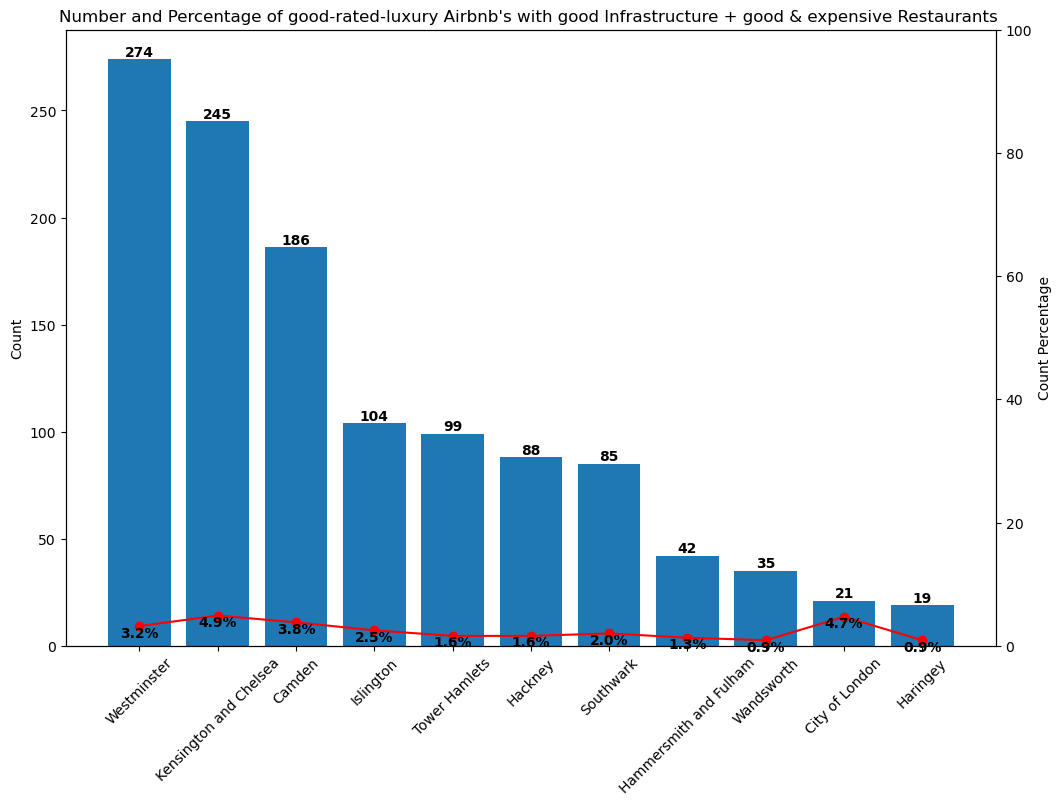

In [253]:
import matplotlib.pyplot as plt

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create bar chart for count column
ax1.bar(plotting_lux.index, plotting_lux['count'])
ax1.set_ylabel('Count')
ax1.set_xticklabels(plotting_lux.index, rotation=45)

# Create secondary axis for count_percentage column
ax2 = ax1.twinx()
ax2.plot(plotting_lux.index, plotting_lux['count_percentage'], color='red', marker='o')
ax2.set_ylim(0, 100)
ax2.set_ylabel('Count Percentage')

# Add count values inside bars
for i, val in enumerate(plotting_lux['count']):
    ax1.text(i, val, str(val), ha='center', va='bottom', fontweight='bold')

# Add count_percentage values inside line plot
for i, val in enumerate(plotting_lux['count_percentage']):
    ax2.text(i, val, f"{val:.1f}%", ha='center', va='top', fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)


plt.title("Number and Percentage of good-rated-luxury Airbnb's with good Infrastructure + good & expensive Restaurants ")
# Show the plot
plt.show();


### #3 Which Neighbourhood is good for: 

* going out 
* foodies 
* shopping 
* culture 

In [254]:
# create new columns for culture & for going out 
poi["culture_500"] = poi["art_500"] + poi["attraction_500"]
poi["going_out_500"] = poi["bar_500"] + poi["cafe_500"]

In [255]:
# calculate the same for all Airbnb's, in order to then calculate the % of Budget friendly Airbnbs 
grouped_3 = poi.groupby(by="neighbourhood").agg(count=("id", "size"),
                                                restaurant_mean=("restaurant_500", "mean"),
                                                clothes_shop_mean=("clothes_shop_500", "mean"),
                                                culture_mean=("culture_500", "mean"),
                                                going_out_mean=("going_out_500", "mean")).reset_index(level=None)


In [256]:
grouped_3["total_mean"] = grouped_3["restaurant_mean"] + grouped_3["clothes_shop_mean"]	+ grouped_3["culture_mean"] + grouped_3["going_out_mean"]

In [257]:
plot_theme = grouped_3.sort_values(by="total_mean", ascending=False).reset_index().head(8)

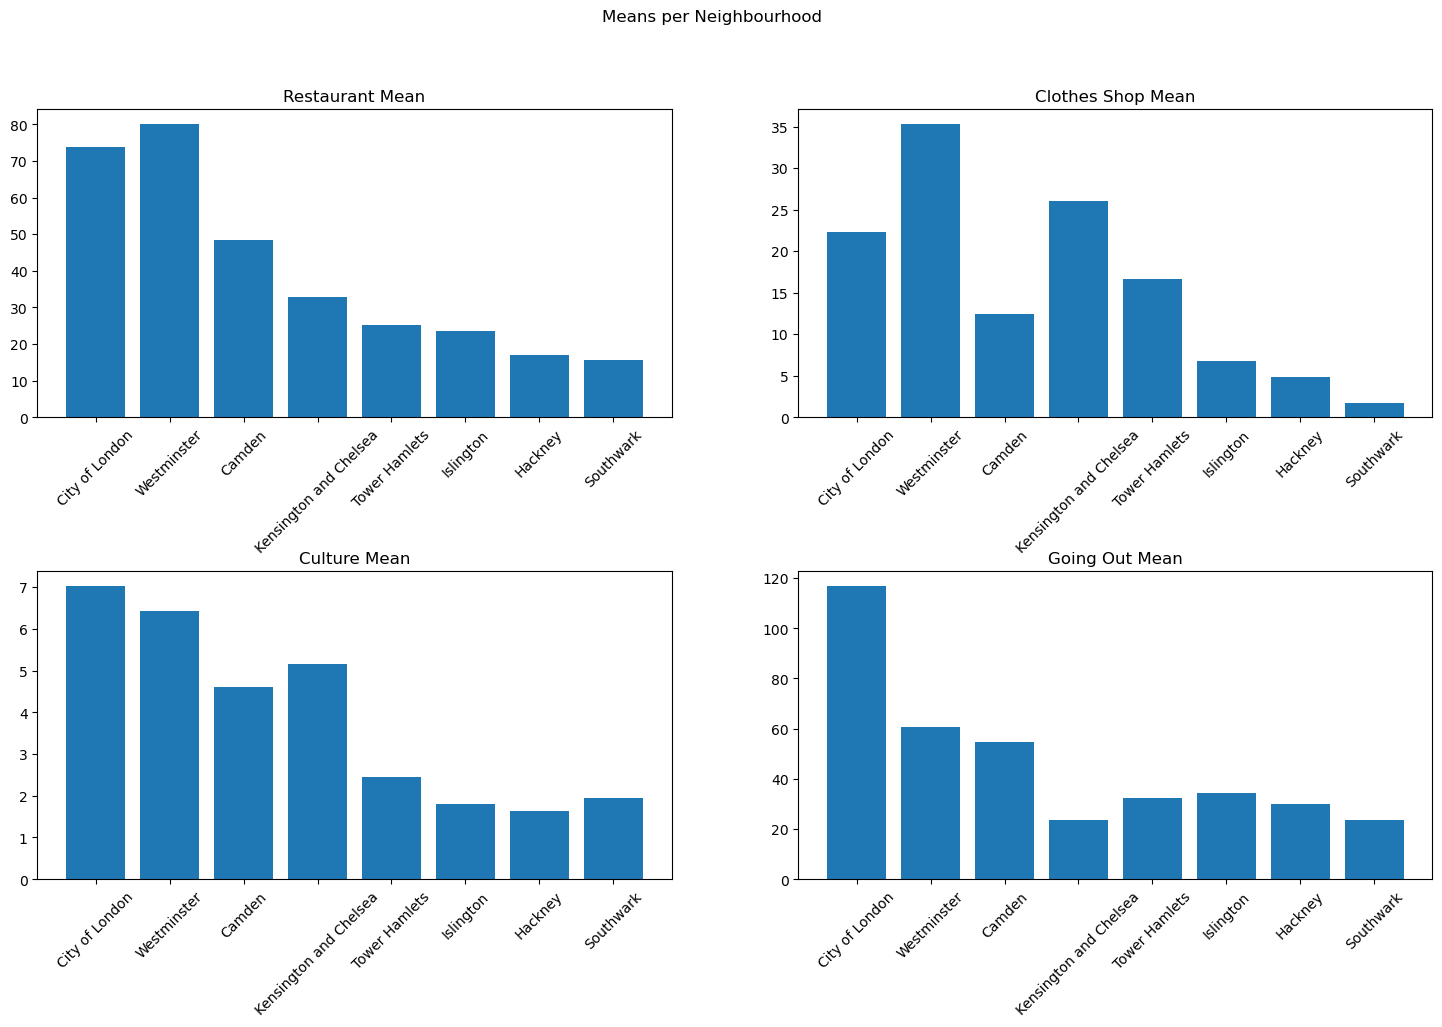

In [258]:
import matplotlib.pyplot as plt

# define the figure size
plt.figure(figsize=(18, 10))

# create the first barplot in the upper left corner
plt.subplot(2, 2, 1)
plt.bar(plot_theme['neighbourhood'], plot_theme['restaurant_mean'])
plt.title('Restaurant Mean')
plt.xticks(rotation=45)

# create the second barplot in the upper right corner
plt.subplot(2, 2, 2)
plt.bar(plot_theme['neighbourhood'], plot_theme['clothes_shop_mean'])
plt.title('Clothes Shop Mean')
plt.xticks(rotation=45)

# create the third barplot in the lower left corner
plt.subplot(2, 2, 3)
plt.bar(plot_theme['neighbourhood'], plot_theme['culture_mean'])
plt.title('Culture Mean')
plt.xticks(rotation=45)

# create the fourth barplot in the lower right corner
plt.subplot(2, 2, 4)
plt.bar(plot_theme['neighbourhood'], plot_theme['going_out_mean'])
plt.title('Going Out Mean')
plt.xticks(rotation=45)

# adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.5)

# add a title for the whole figure
plt.suptitle('Means per Neighbourhood')

# display the plot
plt.show()



### correlation of agglomeration of POI's + Airbnbs

In [ ]:
result.corr()["count"].tail(5)

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_26012/545465742.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  result.corr()["count"].tail(5)


gastro_mean                  0.676863
price_cat_restaurant_mean    0.566810
clothes_shop_mean            0.845325
attraction_mean              0.608648
art_mean                     0.861710
Name: count, dtype: float64

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_26012/1281410096.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  result.corr()["count"].tail(5).plot(kind="bar")


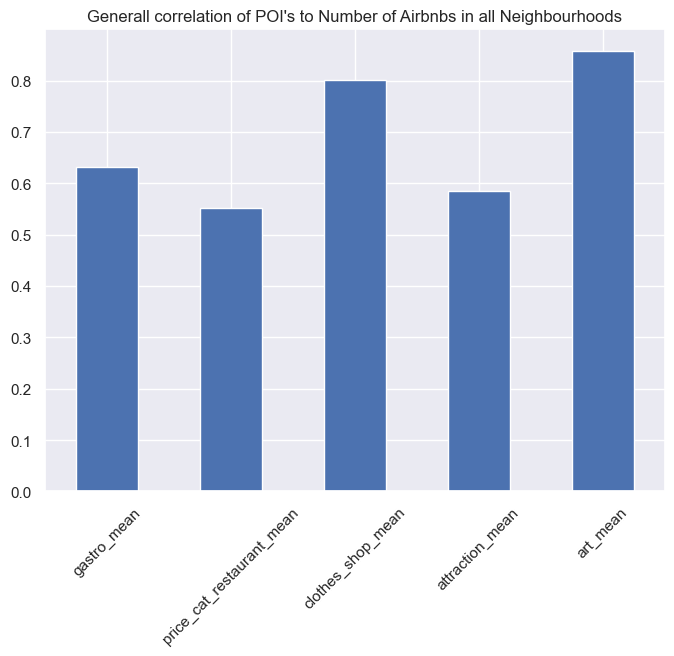

In [ ]:
result.corr()["count"].tail(5).plot(kind="bar")

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Generall correlation of POI's to Number of Airbnbs in all Neighbourhoods")
plt.show()

## EDA: poi (gastro)

### Heatmap

In [ ]:
# set relevant columns for hypothesis 
heat = poi[["price", 
                     "price_category", 
                     "number_of_reviews", 
                     "number_of_reviews_ltm", 
                     "reviews_per_month", 
                     "review_scores_rating",
                     "room_type", 
                     "room_type_int", 
                     "restaurant_500", 
                     "fast_food_500", 
                     "bar_500", 
                     "cafe_500", 
                     "gastro_500"]]

<AxesSubplot: >

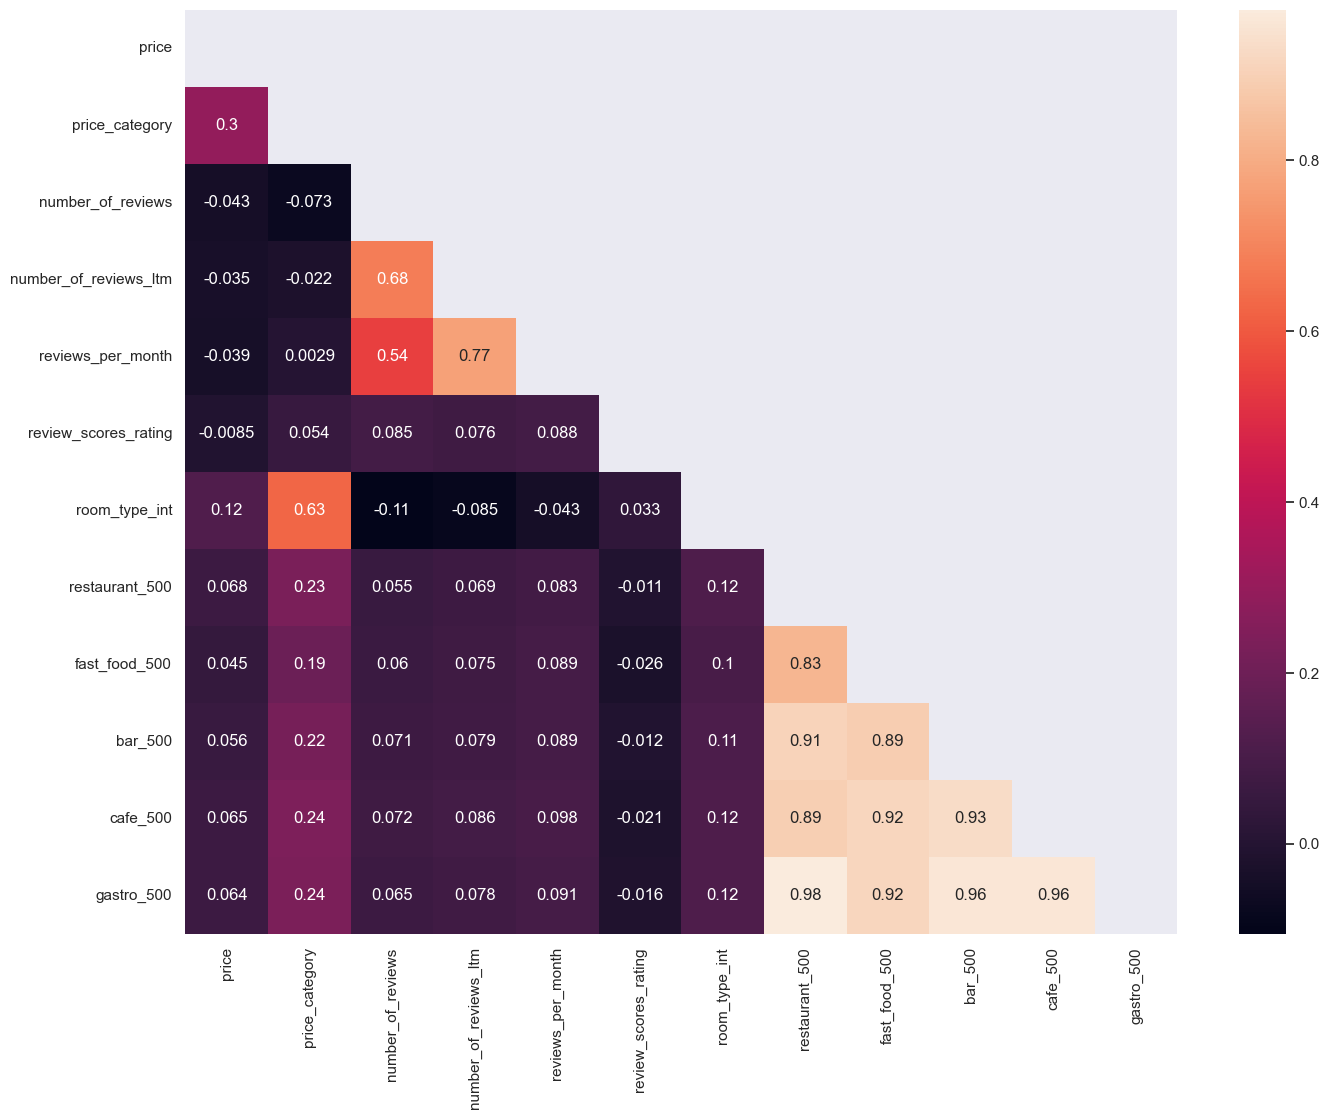

In [ ]:
corr = heat.corr(numeric_only=True)

sns.set(rc={"figure.figsize":(16, 12)})

# getting the upper triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

### Hypothesis: In Area's with lot's of POI's, there are less Airbnb's which offer Entire Homes

In [ ]:
# group by room_type_int and calculate the mean value 
poi.groupby(by="room_type_int").agg({"gastro_500": "mean", 
                                             "restaurant_500": "mean",
                                             "fast_food_500": "mean",
                                             "cafe_500": "mean",
                                             "bar_500": "mean",
                                             "id": "size"})[["gastro_500","restaurant_500","fast_food_500","cafe_500", "bar_500", "id"]]

,gastro_500,restaurant_500,fast_food_500,cafe_500,bar_500,id
room_type_int,,,,,,
1,58.972705,24.446650,10.039702,14.071960,10.414392,403
2,46.056105,16.824836,9.064372,11.513836,8.653061,28910
3,83.144860,36.341121,13.121495,19.766355,13.915888,214
4,69.531916,28.539966,12.025156,16.241917,12.724876,45714


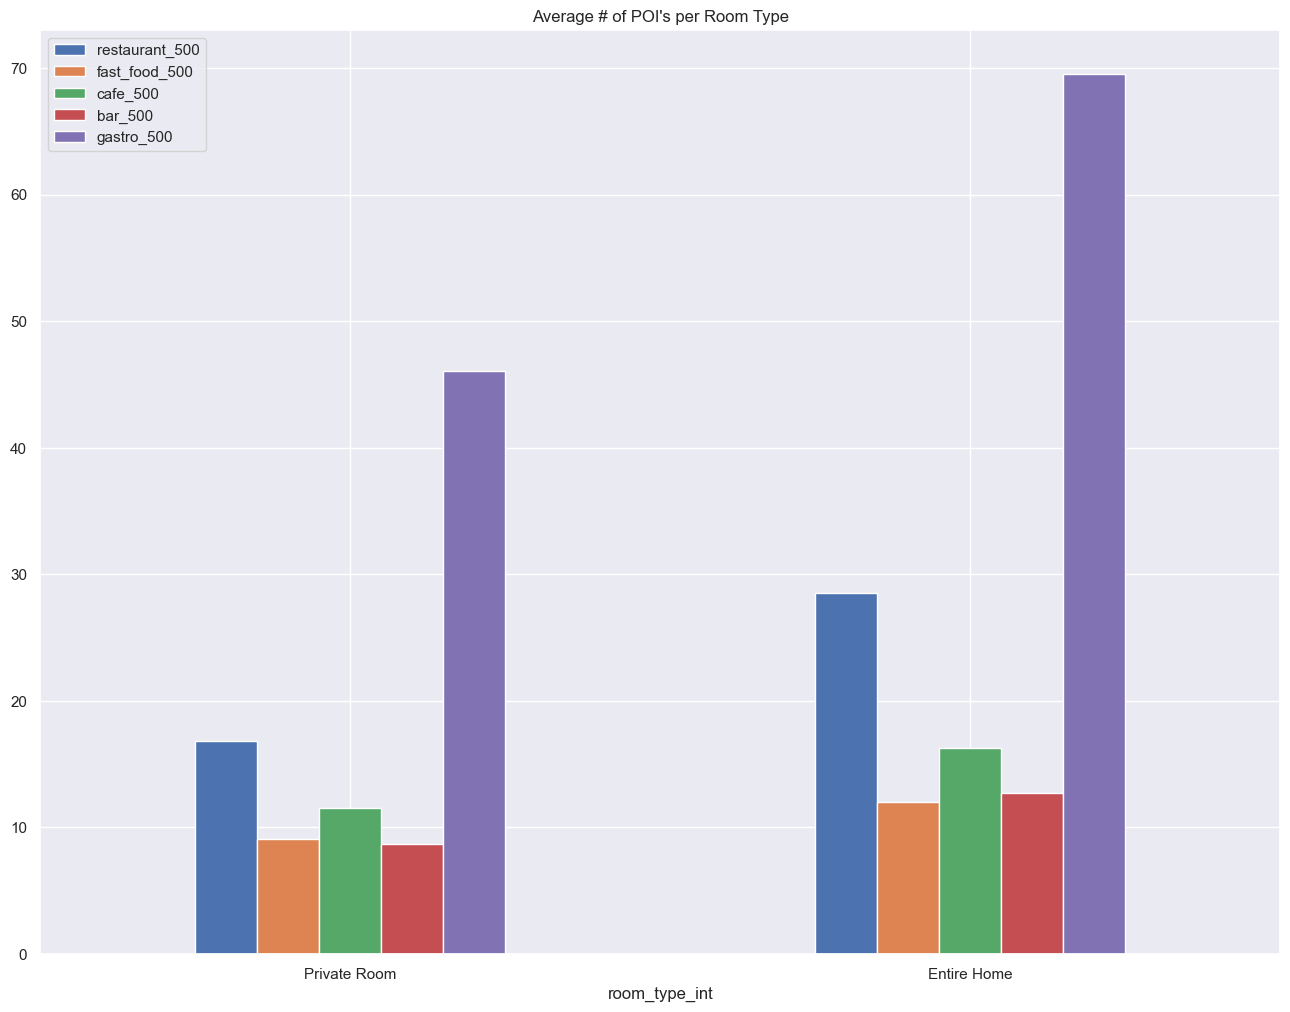

In [ ]:
# plot without category "hotel room(3)" or "shared room (1)"
poi[(poi["room_type_int"] != 1) & (poi["room_type_int"] != 3)].groupby(by="room_type_int").agg({"gastro_500": "mean", 
                                             "restaurant_500": "mean",
                                             "fast_food_500": "mean",
                                             "cafe_500": "mean",
                                             "bar_500": "mean"})[["restaurant_500","fast_food_500","cafe_500", "bar_500", "gastro_500"]].plot(kind="bar")
plt.xticks([0, 1], ["Private Room", "Entire Home"], rotation=360)
plt.title("Average # of POI's per Room Type")
plt.show()

### Hypothesis: POI's have direct impact on Price & Demand of Airbnb's

In [ ]:
# group by price category and calculate the mean value 
poi.groupby(by="price_category").agg({"gastro_500": "mean", 
                                             "restaurant_500": "mean",
                                             "fast_food_500": "mean",
                                             "cafe_500": "mean",
                                             "bar_500": "mean",
                                             "id": "size"})[["gastro_500","restaurant_500","fast_food_500","cafe_500", "bar_500", "id"]]

,gastro_500,restaurant_500,fast_food_500,cafe_500,bar_500,id
price_category,,,,,,
0,104.500000,41.500000,17.071429,24.571429,21.357143,14
1,34.917777,11.697025,7.668699,8.951561,6.600492,20335
2,48.950665,18.069826,9.522691,12.091263,9.266886,17959
3,63.143402,24.581080,11.415265,15.240312,11.906745,18605
4,97.458479,43.017460,15.224902,21.943584,17.272534,18328


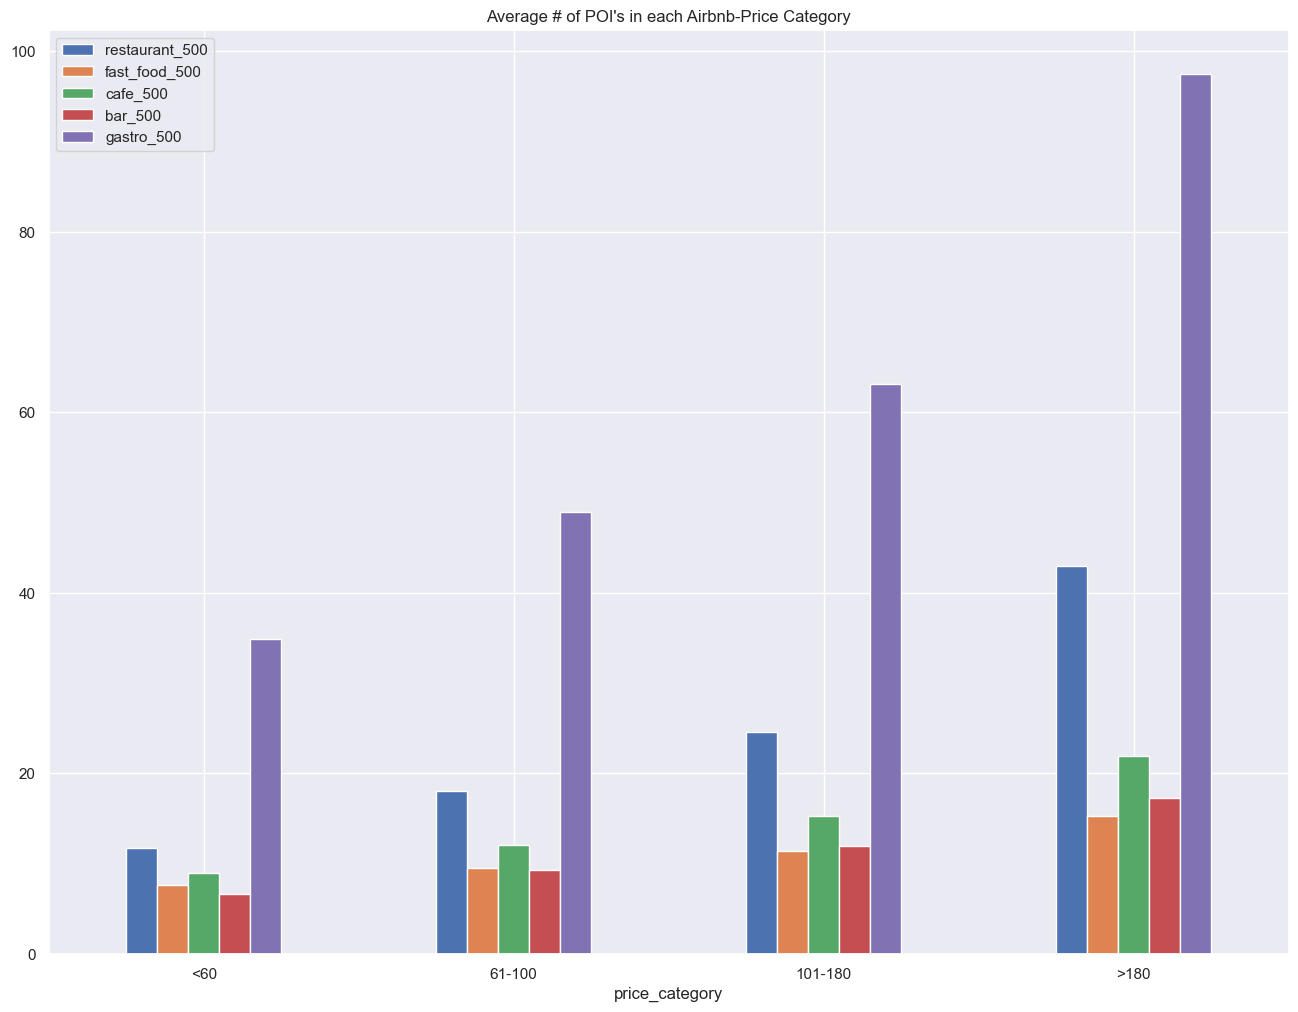

In [ ]:
# plot without category 0 
poi[poi["price_category"] != 0].groupby(by="price_category").agg({"gastro_500": "mean", 
                                             "restaurant_500": "mean",
                                             "fast_food_500": "mean",
                                             "cafe_500": "mean",
                                             "bar_500": "mean"})[["restaurant_500","fast_food_500","cafe_500", "bar_500", "gastro_500"]].plot(kind="bar")

plt.xticks([0, 1, 2, 3], ["<60", "61-100", "101-180", ">180"], rotation=360)
plt.title("Average # of POI's in each Airbnb-Price Category")
plt.show()

### Hypothesis: More POI's == better reviews (for location & general)

### Rating vs. Gastro POI's vs. Price Category

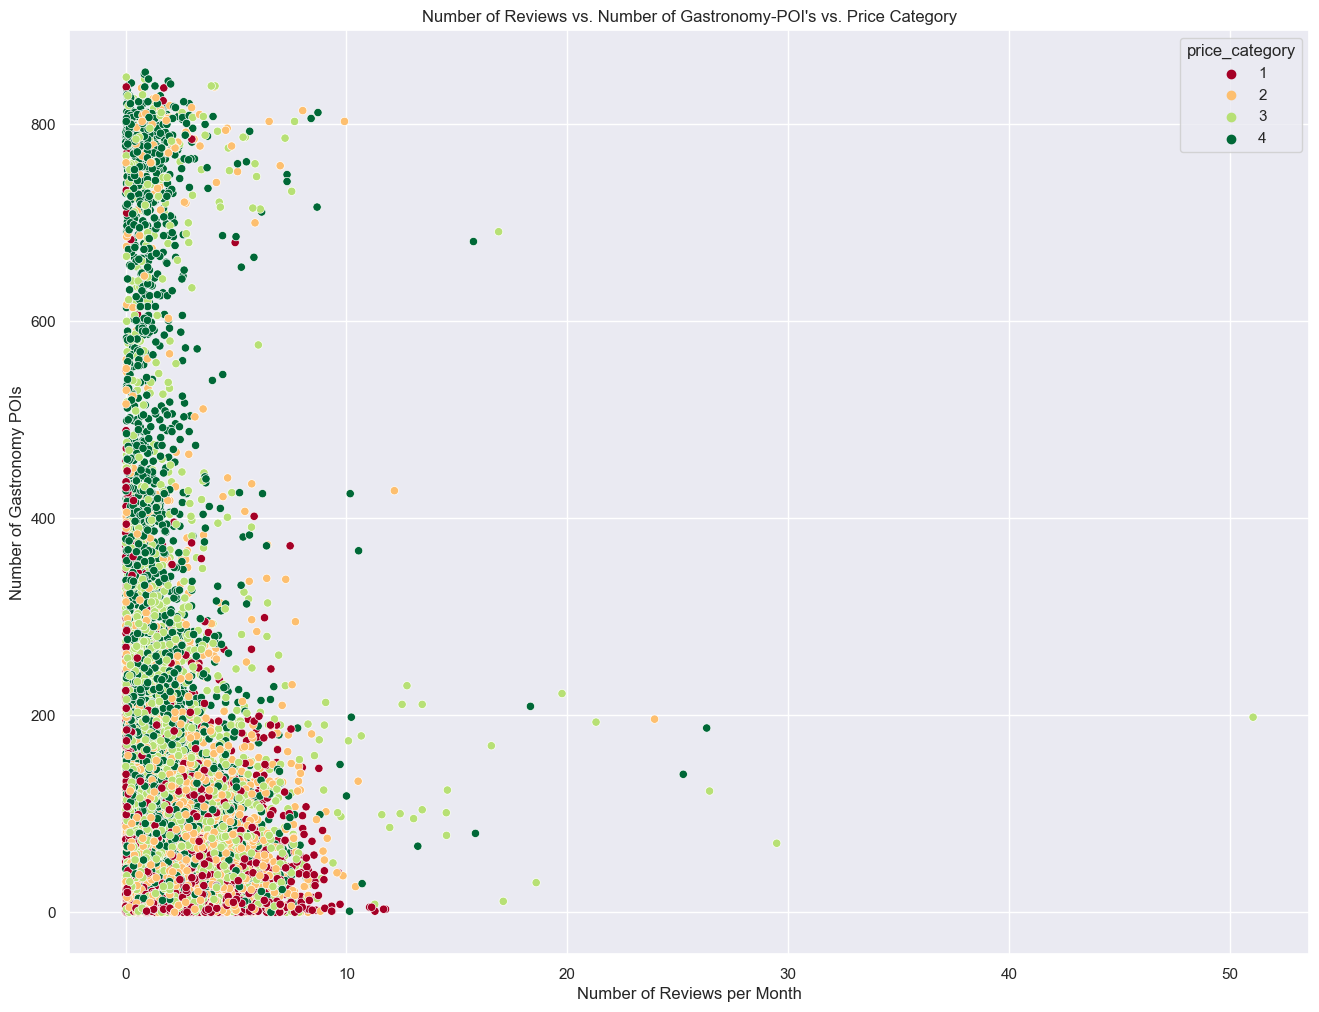

In [ ]:
sns.set(rc={"figure.figsize":(16, 12)})

# Filter only Reviews with > 0 Reviews per Month, without Category 0
poi_gastro_filtered = poi[(poi["reviews_per_month"] > 0) & (poi["price_category"] > 0)]

# Define the red-green color palette
custom_palette = sns.color_palette("RdYlGn", as_cmap=True)

# Create the scatter plot with hue based on review_scores_rating
ax = sns.scatterplot(x="reviews_per_month", y="gastro_500", hue="price_category", data=poi_gastro_filtered, palette=custom_palette)

# Rename the x-axis and y-axis labels
ax.set_xlabel("Number of Reviews per Month")
ax.set_ylabel("Number of Gastronomy POIs")

plt.title("Number of Reviews vs. Number of Gastronomy-POI's vs. Price Category")
plt.show()

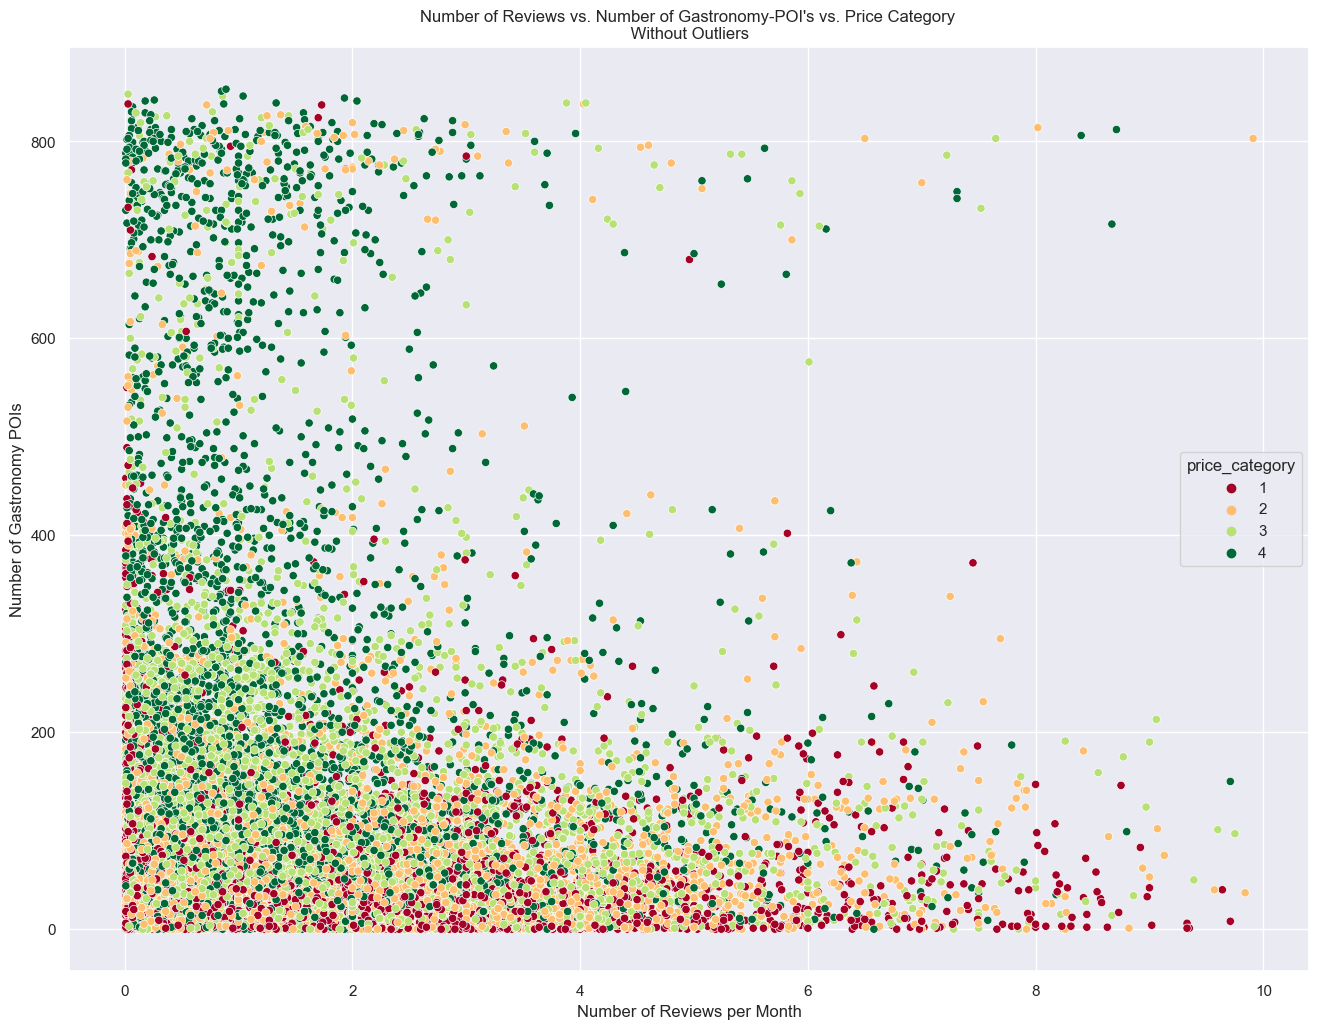

In [ ]:
sns.set(rc={"figure.figsize":(16, 12)})

# Filter only Reviews with > 0 Reviews per Month, without Category 0, and without outliers
poi_gastro_filtered = poi[(poi["reviews_per_month"] > 0) & (poi["reviews_per_month"] < 10) & (poi["price_category"] > 0)]

# Define the red-green color palette
custom_palette = sns.color_palette("RdYlGn", as_cmap=True)

# Create the scatter plot with hue based on review_scores_rating
ax = sns.scatterplot(x="reviews_per_month", y="gastro_500", hue="price_category", data=poi_gastro_filtered, palette=custom_palette)

# Rename the x-axis and y-axis labels
ax.set_xlabel("Number of Reviews per Month")
ax.set_ylabel("Number of Gastronomy POIs")

plt.title("Number of Reviews vs. Number of Gastronomy-POI's vs. Price Category \n Without Outliers ")
plt.show()

### Hypothesis: Certain Amenities have direct impact on Price & Demand of Airbnb's

In [ ]:
#Correlation between price & amenities 

columns = ['private_bath', 'wifi', 'long_term_stays_allowed',
       'private_patio_or_balcony', 'private_entrance', 'pets_allowed',
       'outdoor_dining_area', 'lockbox', 'kitchen', 'hair_dryer',
       'free_street_parking', 'free_parking_on_premises',
       'dedicated_workspace', 'coffee', 'bed_linens',
       'bathtub']


selected_columns = poi[columns]
corr = selected_columns.corrwith(poi["price_category"]).sort_values(ascending=False)

print(corr)

private_bath                0.513564
bed_linens                  0.218300
bathtub                     0.213435
long_term_stays_allowed     0.204076
private_entrance            0.189065
coffee                      0.175759
dedicated_workspace         0.175733
private_patio_or_balcony    0.161972
hair_dryer                  0.157112
lockbox                     0.125381
kitchen                     0.106456
outdoor_dining_area         0.106022
pets_allowed                0.077965
wifi                        0.005614
free_parking_on_premises   -0.089947
free_street_parking        -0.092478
dtype: float64


(-0.1, 0.5)

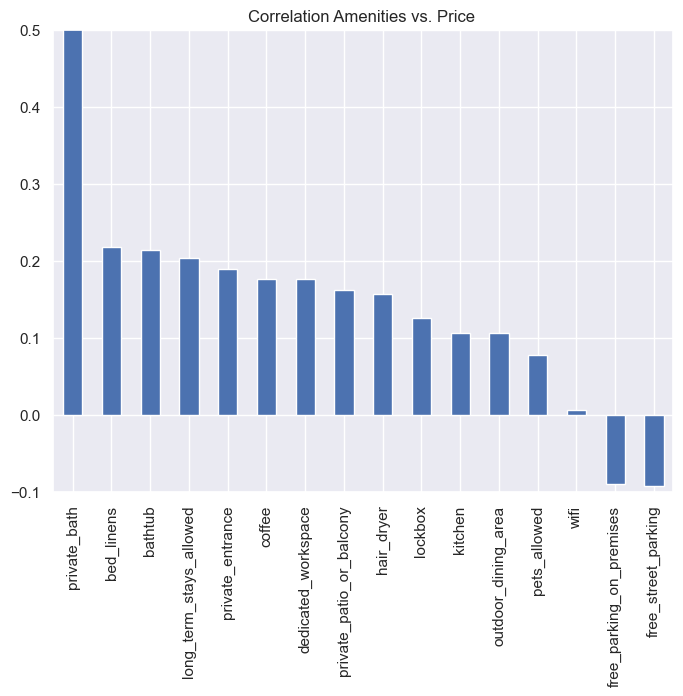

In [ ]:
plt.figure(figsize=(8, 6))

corr.plot(kind="bar")
plt.title("Correlation Amenities vs. Price ")

plt.ylim(-0.1, 0.5)

In [ ]:
#Correlation between amenities & reviews 

columns = ['private_bath', 'wifi', 'long_term_stays_allowed',
       'private_patio_or_balcony', 'private_entrance', 'pets_allowed',
       'outdoor_dining_area', 'lockbox', 'kitchen', 'hair_dryer',
       'free_street_parking', 'free_parking_on_premises',
       'dedicated_workspace', 'coffee', 'bed_linens',
       'bathtub']


selected_columns = poi[columns]
corr = selected_columns.corrwith(poi["review_scores_rating"]).sort_values(ascending=False)

print(corr)

coffee                      0.139067
bed_linens                  0.116058
hair_dryer                  0.116018
bathtub                     0.111249
private_patio_or_balcony    0.100943
dedicated_workspace         0.094047
outdoor_dining_area         0.092537
free_street_parking         0.071810
lockbox                     0.063410
long_term_stays_allowed     0.059237
private_entrance            0.038701
kitchen                     0.017065
private_bath                0.004981
pets_allowed                0.004042
free_parking_on_premises   -0.001515
wifi                       -0.023244
dtype: float64


(-0.1, 0.5)

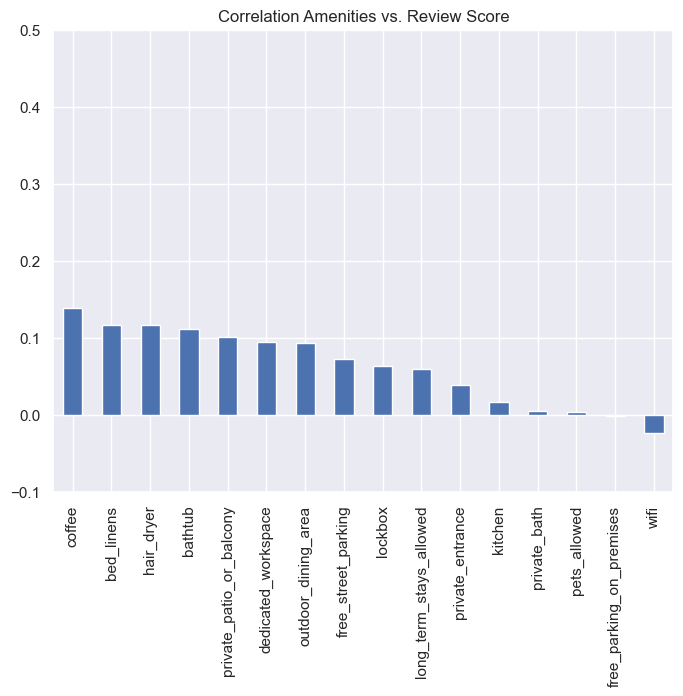

In [ ]:
plt.figure(figsize=(8, 6))

corr.plot(kind="bar")
plt.title("Correlation Amenities vs. Review Score")

plt.ylim(-0.1, 0.5)

## Calculation in Python

didnt work properly. still has to be checked

### POI in Area

In [ ]:
# ### subset's of df's for each amenity 
# restaurant = osm_short[osm_short["amenity"] == "restaurant"][['id', 'latitude', 'longitude', 'name', 'amenity']]
# fast_food = osm_short[osm_short["amenity"] == "fast_food"][['id', 'latitude', 'longitude', 'name', 'amenity']]
# cafe = osm_short[osm_short["amenity"] == "cafe"][['id', 'latitude', 'longitude', 'name', 'amenity']]
# bar = osm_short[osm_short["amenity"] == "bar"][['id', 'latitude', 'longitude', 'name', 'amenity']]
# subway = osm_short[osm_short["railway"] == "subway_entrance"][['id', 'latitude', 'longitude', 'name', 'railway']]

# street_test = osm_short[["id", "latitude", "longitude", "amenity"]]

In [ ]:
# airbnb_short = airbnb[['id', 'latitude', 'longitude']]

#### Function meters_to_degrees

In [ ]:
# # Define the conversion factor from meters to degrees based on the latitude
# def meters_to_degrees(meters, latitude):
#     proj_meters = pyproj.CRS("EPSG:3857")  # meters
#     proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
#     transformer = pyproj.Transformer.from_crs(
#         proj_meters, proj_latlon, always_xy=True)
#     lon, lat = transformer.transform(meters, 0)

#     # Calculate the distance per degree of latitude
#     lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(
#         4 * math.radians(latitude)) - 0.0023 * math.cos(6 * math.radians(latitude))

#     # Calculate the distance per degree of longitude
#     lon_dist_per_deg = math.pi / 180 * 6378137 * \
#         math.cos(math.radians(latitude))

#     lat_degrees = meters / lat_dist_per_deg
#     lon_degrees = meters / lon_dist_per_deg
#     return lat_degrees, lon_degrees

### 100 Meter

In [ ]:
# # ignore seetingswithcopy only for this cell. will be set back to warn at the end of the code
# pd.options.mode.chained_assignment = None

# # Convert the airbnb_short DataFrame to a GeoDataFrame with a Point geometry column
# airbnb_geo = gpd.GeoDataFrame(airbnb_short, geometry=gpd.points_from_xy( airbnb_short["longitude"], airbnb_short["latitude"]))

# # Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
# street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# # Create an array of coordinates for the street_test GeoDataFrame
# X = np.column_stack((street_test_geo["longitude"].values, street_test_geo["latitude"].values))

# # Create a BallTree spatial index for the street_test GeoDataFrame
# tree = BallTree(X, leaf_size=40)

# # Define the radius of the search in meters
# radius_meters = 100

# # Loop through each row in airbnb_geo
# for index, row in airbnb_geo.iterrows():
#     # Convert the radius from meters to degrees based on the latitude
#     lat, lon = row["latitude"], row["longitude"]
#     lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)

#     # Use the BallTree spatial index to find the street_test rows within the search radius
#     indices = tree.query_radius([[row["longitude"], row["latitude"]]], r=lon_deg)[0]

#     # Filter the street_test rows to only those within the search radius
#     candidate_rows = street_test_geo.iloc[indices]

#     # Count the occurrences of each amenity in the candidate rows
#     counts = candidate_rows["amenity"].value_counts().to_dict()

#     # Add the counts as new columns in the airbnb_short DataFrame
#     for amenity_type, count in counts.items():
#         airbnb_short.at[index, amenity_type] = count

# #    # Add the list of ids as a new column in the airbnb_short
# #    airbnb_short.at[index, "street_test_ids"] = str(candidate_rows["id"].tolist())

#     # If there are no amenities in the given radius, append "no amenities" in the list of ids
# #    if not candidate_rows["id"].tolist():
# #        airbnb_short.at[index, "street_test_ids"] = "no amenities"

#     # Print progress
#     if index % 10000 == 0:
#         print(f"Processed {index} rows")

# # Replace NaN values with 0
# airbnb_short.fillna(value=0, inplace=True)

# pd.options.mode.chained_assignment = 'warn'

### Nearest distance 

In [ ]:
# ### is calculating values, but they seem to small
# from scipy.spatial import cKDTree

# # Import the radians function from numpy
# from numpy import radians

# # Convert the latitude and longitude columns in both dataframes to radians
# airbnb[['latitude', 'longitude']] = radians(airbnb[['latitude', 'longitude']])
# subway[['latitude', 'longitude']] = radians(subway[['latitude', 'longitude']])

# # Build the KDTree index using the radians converted latitude and longitude columns in the subway dataframe
# subway_tree = cKDTree(subway[['latitude', 'longitude']])

# # Query the KDTree index for the nearest subway station to each airbnb location
# distances, indices = subway_tree.query(airbnb[['latitude', 'longitude']], k=1)

# # Convert the distance from radians to meters
# earth_radius = 6371000  # radius of the Earth in meters
# distances_meters = distances * earth_radius

# # Add the nearest subway station distance to each airbnb row
# airbnb['nearest_subway_distance'] = distances_meters



In [ ]:
#airbnb['nearest_subway_distance'].describe()

## Old

In [ ]:
# ### runs, but with too smal results 

# # ignore seetingswithcopy only for this cell. will be set back to warn at the end of the code 
# pd.options.mode.chained_assignment = None

# # Define the conversion factor from meters to degrees based on the latitude
# def meters_to_degrees(meters, latitude):
#     proj_meters = pyproj.CRS("EPSG:3857")  # meters
#     proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
#     transformer = pyproj.Transformer.from_crs(proj_meters, proj_latlon, always_xy=True)
#     lon, lat = transformer.transform(meters, 0)
#     lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(4 * math.radians(latitude))
#     lon_dist_per_deg = 111412.84 * math.cos(math.radians(latitude))
#     lat_degrees = meters / lat_dist_per_deg
#     lon_degrees = meters / lon_dist_per_deg
#     return lat_degrees, lon_degrees


# airbnb_test["closest_amenity"] = ""


# # Convert the airbnb_test DataFrame to a GeoDataFrame with a Point geometry column
# airbnb_test_geo = gpd.GeoDataFrame(airbnb_test, geometry=gpd.points_from_xy(airbnb_test["longitude"], airbnb_test["latitude"]))

# # Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
# street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# # Create an R-tree spatial index for the street_test GeoDataFrame
# street_test_sindex = street_test_geo.sindex

# # Define the radius of the search in meters
# radius_meters = 1_000

# # Loop through each row in airbnb_test_geo
# for index, row in airbnb_test_geo.iterrows():
#     # Convert the radius from meters to degrees based on the latitude
#     lat, lon = row["latitude"], row["longitude"]
#     lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)
    
#     # Use the R-tree spatial index to find the street_test rows within the search radius
#     candidate_indices = list(street_test_sindex.intersection(row.geometry.buffer(lon_deg).bounds))

#     # Filter the street_test rows to only those within the search radius
#     candidate_rows = street_test_geo.iloc[candidate_indices]
# #
#     if len(candidate_rows) == 0:
#         # No amenities within the search radius
#         closest_amenity_distance = np.nan
#     else:
#         # Calculate the distances from the current Airbnb location to all the amenities in the search radius
#         candidate_rows["distance"] = candidate_rows.geometry.distance(row.geometry)

#         # Sort the candidate rows by distance
#         candidate_rows = candidate_rows.sort_values("distance")

#         # Find the closest amenity and its distance
#         closest_amenity = candidate_rows["amenity"].iloc[0]
#         closest_amenity_distance = candidate_rows["distance"].iloc[0]

#     # Add the closest amenity and its distance as new columns in the airbnb_test DataFrame
#     airbnb_test.at[index, "closest_amenity"] = closest_amenity
#     airbnb_test.at[index, "closest_amenity_distance_m"] = closest_amenity_distance

#     # Print progress
#     if index % 10000 == 0:
#         print(f"Processed {index} rows")

# # set seetingswithcopy back only for this cell. will be set back to warn at the end of the code 
# pd.options.mode.chained_assignment = 'warn'


In [ ]:
#airbnb_test.describe()

In [ ]:
# ### runs, but with less accurate results, than in 4.1.

# ### Number of amenities + liste 

# import geopandas as gpd
# from shapely.geometry import Point
# from shapely.ops import transform
# from functools import partial
# import pyproj
# import math

# # Define the conversion factor from meters to degrees based on the latitude
# def meters_to_degrees(meters, latitude):
#     proj_meters = pyproj.CRS("EPSG:3857")  # meters
#     proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
#     transformer = pyproj.Transformer.from_crs(
#         proj_meters, proj_latlon, always_xy=True)
#     lon, lat = transformer.transform(meters, 0)

#     # Calculate the distance per degree of latitude
#     lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(
#         4 * math.radians(latitude)) - 0.0023 * math.cos(6 * math.radians(latitude))

#     # Calculate the distance per degree of longitude
#     lon_dist_per_deg = math.pi / 180 * 6378137 * \
#         math.cos(math.radians(latitude))

#     lat_degrees = meters / lat_dist_per_deg
#     lon_degrees = meters / lon_dist_per_deg
#     return lat_degrees, lon_degrees


# # Convert the airbnb_test DataFrame to a GeoDataFrame with a Point geometry column
# airbnb_test_geo = gpd.GeoDataFrame(airbnb_test, geometry=gpd.points_from_xy(airbnb_test["longitude"], airbnb_test["latitude"]))

# # Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
# street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# # Create an R-tree spatial index for the street_test GeoDataFrame
# street_test_sindex = street_test_geo.sindex

# # Define the radius of the search in meters
# radius_meters = 200

# # Loop through each row in airbnb_test_geo
# for index, row in airbnb_test_geo.iterrows():
#     # Convert the radius from meters to degrees based on the latitude
#     lat, lon = row["latitude"], row["longitude"]
#     lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)
    
#     # Use the R-tree spatial index to find the street_test rows within the search radius
#     candidate_indices = list(street_test_sindex.intersection(row.geometry.buffer(lon_deg).bounds))

#     # Filter the street_test rows to only those within the search radius
#     candidate_rows = street_test_geo.iloc[candidate_indices]

#     # Create an empty list to store the id's of street_test rows
#     ids = []

#     # Group the candidate rows by amenity and count the occurrences
#     counts = candidate_rows.groupby("amenity").size().to_dict()

#     # Add the counts as new columns in the airbnb_test DataFrame
#     for amenity_type, count in counts.items():
#         airbnb_test.at[index, amenity_type] = count
#         ids.extend(candidate_rows[candidate_rows["amenity"] == amenity_type]["id"].tolist())

#     # If there are no amenities in the given radius, append "no amenities" in the list of ids
#     if not ids:
#         ids.append("no amenities")
        
#     # Add the list of ids as a new column in the airbnb_test DataFrame
#     airbnb_test.at[index, "street_test_ids"] = str(ids)

#     # Print progress
#     if index % 10000 == 0:
#         print(f"Processed {index} rows")

# # Replace NaN values with 0
# airbnb_test.fillna(value=0, inplace=True)



In [ ]:
# ### Calculation of POI's in Area with Balltree (old, not working properly)

# # Calculate the needed radius when converted to unit sphere.
# distance_in_meter = 200
# earth_radius_in_meter = 6_371_000

# radius = distance_in_meter / earth_radius_in_meter

# # Convert the latitude and longitude columns to radians
# airbnb_test = airbnb_test.copy()
# airbnb_test.loc[:, 'lat_rad'] = np.radians(airbnb_test['latitude'])
# airbnb_test.loc[:, 'lon_rad'] = np.radians(airbnb_test['longitude'])
# street_test = street_test.copy()
# street_test.loc[:, 'lat_rad'] = np.radians(street_test['latitude'])
# street_test.loc[:, 'lon_rad'] = np.radians(street_test['longitude'])

# # Create a BallTree object with the latitude and longitude columns
# tree = BallTree(street_test[['lat_rad', 'lon_rad']],
#                 leaf_size=15, metric='haversine')

# # Find the indices of all neighbors within a radius of 500 meters
# # for each row in list_test
# indices = tree.query_radius(
#     airbnb_test[['lat_rad', 'lon_rad']], r=radius, count_only=False)

# # Calculate the number of neighbors for each amenity type
# amenity_types = street_test['amenity'].unique()
# amenity_counts = np.zeros((airbnb_test.shape[0], amenity_types.shape[0]))
# for i, amenity in enumerate(amenity_types):
#     street_indices = street_test[street_test['amenity'] == amenity].index
#     intersection_counts = np.array(
#         [np.intersect1d(street_indices, idx).size for idx in indices])
#     amenity_counts[:, i] = intersection_counts

# # Add the new columns to list_test
# list_test = pd.concat([airbnb_test, pd.DataFrame(amenity_counts, columns=[
#                       f'num_neighbors_{amenity}' for amenity in amenity_types])], axis=1)

# # Calculate the number of neighbors for each railway type
# railway_types = street_test['railway'].unique()
# railway_counts = np.zeros((list_test.shape[0], railway_types.shape[0]))
# for i, railway in enumerate(railway_types):
#     street_indices = street_test[street_test['railway'] == railway].index
#     intersection_counts = np.array(
#         [np.intersect1d(street_indices, idx).size for idx in indices])
#     railway_counts[:, i] = intersection_counts

# # Add the new columns to list_test
# list_test = pd.concat([list_test, pd.DataFrame(railway_counts, columns=[
#                       f'num_neighbors_{railway}' for railway in railway_types])], axis=1)


# # Remove the temporary columns
# list_test.drop(columns=['lat_rad', 'lon_rad'], inplace=True)
# street_test.drop(columns=['lat_rad', 'lon_rad'], inplace=True)


### Nearest Station-old

In [ ]:
# from haversine import haversine, Unit

# # define a function to calculate distance between two points
# def calc_distance(lat1, lon1, lat2, lon2):
#     return haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)

# # get all unique values in "tags.railway" that are present in airbnb
# railway_tags = airbnb["railway"].unique()

# # loop through each row in airbnb and calculate the minimum distance
# # for each value in airbnb["railway"]
# for tag in railway_tags:
#     distances = []
#     for _, row in airbnb[airbnb["railway"] == tag].iterrows():
#         min_distance = None
#         for _, sm_row in osm_short[osm_short["railway"] == tag].iterrows():
#             distance = calc_distance(row["latitude"], row["longitude"], sm_row["latitude"], sm_row["longitude"])
#             if min_distance is None or distance < min_distance:
#                 min_distance = distance
#         distances.append(min_distance)

#     # add the calculated minimum distances as a new column in airbnb
#     col_name = "min_distance_{}".format(tag)
#     airbnb.loc[airbnb["railway"] == tag, col_name] = distances


In [ ]:
# from haversine import haversine, Unit

# # define a function to calculate distance between two points
# def calc_distance(lat1, lon1, lat2, lon2):
#     return haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)

# # only one value in "tags.railway", so use it directly in the loop
# tag = "restaurant"

# distances = []
# for _, row in airbnb.iterrows():
#     min_distance = None
#     for _, sm_row in osm_short[osm_short["amenity"] == tag].iterrows():
#         distance = calc_distance(row["latitude"], row["longitude"], sm_row["latitude"], sm_row["longitude"])
#         if min_distance is None or distance < min_distance:
#             min_distance = distance
#     distances.append(min_distance)

# # add the calculated minimum distances as a new column in airbnb
# col_name = "min_distance_{}".format(tag)
# airbnb[col_name] = distances
